Predecir la cantidad de ovocitos aspirados (ASPIRADOS_TOTAL) en pacientes, usando como variables predictoras la edad, AMH, FSH, AFC, dosis, duraci√≥n de estimulaci√≥n y tipo de gonadotropinas utilizadas.

In [ ]:
                                                      #INSTALAMOS LAS LIBRERIAS NECESARIAS
# Cargamos las librer√≠as esenciales para el an√°lisis de datos y el modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


In [ ]:
data = pd.read_excel("/content/solo pacientes.xlsx")

data.head(5)

Link  Inicio prot  OvocitoNumero.- SEXO_OK_MUJER ETIOLOGIA_OK_MUJER  \
0  2160800            1                2           NaN                NaN   
1  2160800            0                3           NaN                NaN   
2  2160800            0                4           NaN                NaN   
3  2160800            0                5           NaN                NaN   
4  2160800            0                6           NaN                NaN   

   Etiolog√≠a femenina normal  Edad materna avanzada  Alteraci√≥n ov√°rica  \
0                        NaN                    NaN                 NaN   
1                        NaN                    NaN                 NaN   
2                        NaN                    NaN                 NaN   
3                        NaN                    NaN                 NaN   
4                        NaN                    NaN                 NaN   

   Alteraci√≥n tub√°rica  Alteraci√≥n uterina  ...  ESDFul.N2 Maximum Flow  \
0                  NaN                 NaN  ...                     0.0   
1                  NaN                 NaN  ...                     0.0   
2                  NaN                 NaN  ...                     0.0   
3                  NaN                 NaN  ...                     0.0   
4                  NaN                 NaN  ...                     0.0   

   ESDFul.N2 Flow Deviation  ESDFul.N2 Average Pressure  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   

   ESDFul.N2 Minimum Pressure  ESDFul.N2 Maximum Pressure  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   ESDFul.N2 Pressure Deviation  ESDFul.Temperature Average  \
0                           0.0                      37.051   
1                           0.0                      37.051   
2                           0.0                      37.051   
3                           0.0                      37.051   
4                           0.0                      37.051   

   ESDFul.Temperature Minimum  ESDFul.Temperature Maximum  \
0                       37.04                       37.06   
1                       37.04                       37.06   
2                       37.04                       37.06   
3                       37.04                       37.06   
4                       37.04                       37.06   

  ESDFul.Temperature Deviation  
0                        0.005  
1                        0.005  
2                        0.005  
3                        0.005  
4                        0.005  

[5 rows x 239 columns]

In [ ]:
# Seleccionar la correlaci√≥n con la variable objetivo
# Calcular la matriz de correlaci√≥n con las variables num√©ricas
correlation_matrix = data.corr(numeric_only=True)

target_corr = correlation_matrix["ASPIRADOS_TOTAL"].drop("ASPIRADOS_TOTAL")  # Excluye a s√≠ misma

# Ordenar por fuerza de correlaci√≥n (de mayor a menor, absolutas)
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# Mostrar solo las m√°s fuertes (por ejemplo, mayores a 0.3 o menores a -0.3)
strong_corr = target_corr_sorted[(target_corr_sorted >= 0.3) | (target_corr_sorted <= -0.3)]

print("Variables con mayor correlaci√≥n positiva o negativa con ASPIRADOS_TOTAL:\n")
print(strong_corr)


Variables con mayor correlaci√≥n positiva o negativa con ASPIRADOS_TOTAL:

N_OVO_ASPIRADOS_IN.-_OK            1.000000
OVO_MII_INSEMIN_IN.-_OK            0.920414
OVO_MII_2PN_IN.-_OK                0.836542
N√∫mero de blastos intrapaciente    0.698300
ID_OVOCITO.-_OK                    0.624787
OvocitoNumero.-                    0.581144
Embryo ID                          0.581144
ANTIUMULLERIANA_DE                 0.562105
EMB_MII_CONGE_IN.-_OK              0.531020
TOTAL EMB (TRF + C)_OK             0.496779
RFA                                0.492027
N_FOLIC_ANTRAL_DER_IN.-            0.478388
NUM_EMBRIONES_CL_OK                0.478319
N_FOLIC_ANTRAL_IZQ_IN.-            0.463319
Dosis alta (>2500)                 0.376561
Well                               0.322509
Name: ASPIRADOS_TOTAL, dtype: float64


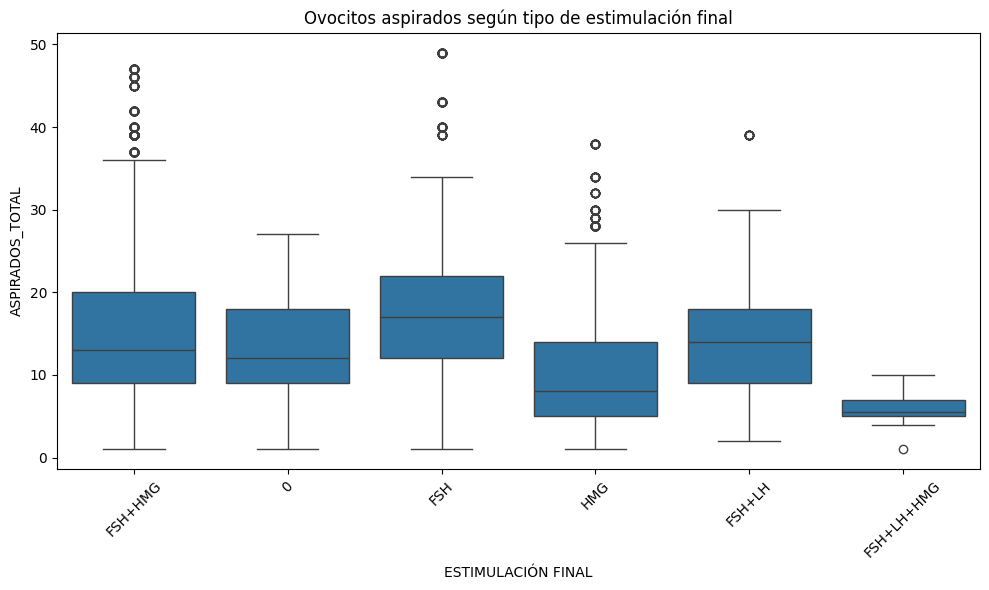

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=data, x='ESTIMULACI√ìN FINAL', y='ASPIRADOS_TOTAL')
plt.xticks(rotation=45)
plt.title('Ovocitos aspirados seg√∫n tipo de estimulaci√≥n final')
plt.tight_layout()
plt.show()


In [ ]:
data["ESTIMULACI√ìN FINAL"].value_counts()

ESTIMULACI√ìN FINAL
FSH+HMG       22013
FSH            3394
HMG            2716
0              1884
FSH+LH         1260
FSH+LH+HMG       36
Name: count, dtype: int64

In [ ]:
grupo_0 = data[data['ESTIMULACI√ìN FINAL'] == 0]
grupo_otros = data[data['ESTIMULACI√ìN FINAL'] != 0]

print("Media de ovocitos - protocolo 0:", grupo_0['ASPIRADOS_TOTAL'].mean())
print("Media de ovocitos - otros protocolos:", grupo_otros['ASPIRADOS_TOTAL'].mean())


Media de ovocitos - protocolo 0: 13.63089430894309
Media de ovocitos - otros protocolos: 14.900327127337345


In [ ]:
# 1. Filtramos el grupo 0
grupo_0 = data[data['ESTIMULACI√ìN FINAL'] == 0]

# 2. Calculamos la matriz de correlaci√≥n solo para variables num√©ricas
correlation_matrix = grupo_0.corr(numeric_only=True)

# 3. Seleccionamos la correlaci√≥n con 'ASPIRADOS_TOTAL' y descartamos la autocorrelaci√≥n
target_corr = correlation_matrix['ASPIRADOS_TOTAL'].drop(labels=['ASPIRADOS_TOTAL'])

# 4. Ordenamos por fuerza de correlaci√≥n (en valor absoluto)
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# 5. Mostramos las m√°s fuertes (mayor a 0.3 o menor a -0.3)
strong_corr = target_corr_sorted[(target_corr_sorted >= 0.3) | (target_corr_sorted <= -0.3)]

# 6. Imprimimos el resultado
print("Variables con mayor correlaci√≥n positiva o negativa con ASPIRADOS_TOTAL en el grupo con protocolo 0:\n")
print(strong_corr)


Variables con mayor correlaci√≥n positiva o negativa con ASPIRADOS_TOTAL en el grupo con protocolo 0:

N_OVO_ASPIRADOS_IN.-_OK            1.000000
OVO_MII_INSEMIN_IN.-_OK            0.940214
OVO_MII_2PN_IN.-_OK                0.809978
N√∫mero de blastos intrapaciente    0.728611
OVO_MII_3PN_IN.-_OK                0.725281
EMB_MII_CONGE_IN.-_OK              0.683382
TOTAL EMB (TRF + C)_OK             0.659079
NUM_EMBRIONES_CL_OK                0.638242
INDUCCION1                         0.566382
OvocitoNumero.-                    0.541764
Embryo ID                          0.541764
P4_DHCG_DE.-                       0.491907
ULT_LIN_ENDOM                      0.484096
DONOR BMI                          0.459336
N_Fetuses                         -0.452069
N_FOLIC_ANTRAL_IZQ_IN.-            0.410976
ID_OVOCITO.-_OK                    0.390799
RFA                                0.350568
N_LB                              -0.349881
Well                               0.345664
MAYOR DE 35 A√ëO

In [ ]:
subset = data[data['ESTIMULACI√ìN FINAL'] == '0']
con_ovocitos = subset[subset['N_OVO_ASPIRADOS_IN.-_OK'] > 0]
print(f"{len(con_ovocitos)} de {len(subset)} pacientes obtuvieron ovocitos.")


0 de 0 pacientes obtuvieron ovocitos.


üìå Estad√≠sticas descriptivas del grupo con protocolo 0:

       PATIENT AGE  ANTIUMULLERIANA_DE         RFA  N_FOLIC_ANTRAL_DER_IN.-  \
count   319.000000          319.000000  319.000000               319.000000   
mean     36.043887           14.934357   12.442006                 6.335423   
std       2.748004            7.079948    4.535907                 2.539691   
min      30.000000            5.610000    4.000000                 2.000000   
25%      34.000000            9.285000    9.000000                 4.000000   
50%      36.000000           13.750000   12.000000                 6.000000   
75%      38.000000           18.020000   14.000000                 7.000000   
max      41.000000           63.220000   27.000000                15.000000   

       N_FOLIC_ANTRAL_IZQ_IN.-  PATIENT BMI  ASPIRADOS_TOTAL  
count               319.000000   319.000000       319.000000  
mean                  6.106583    23.353636        12.934169  
std                   2.587085     2.88

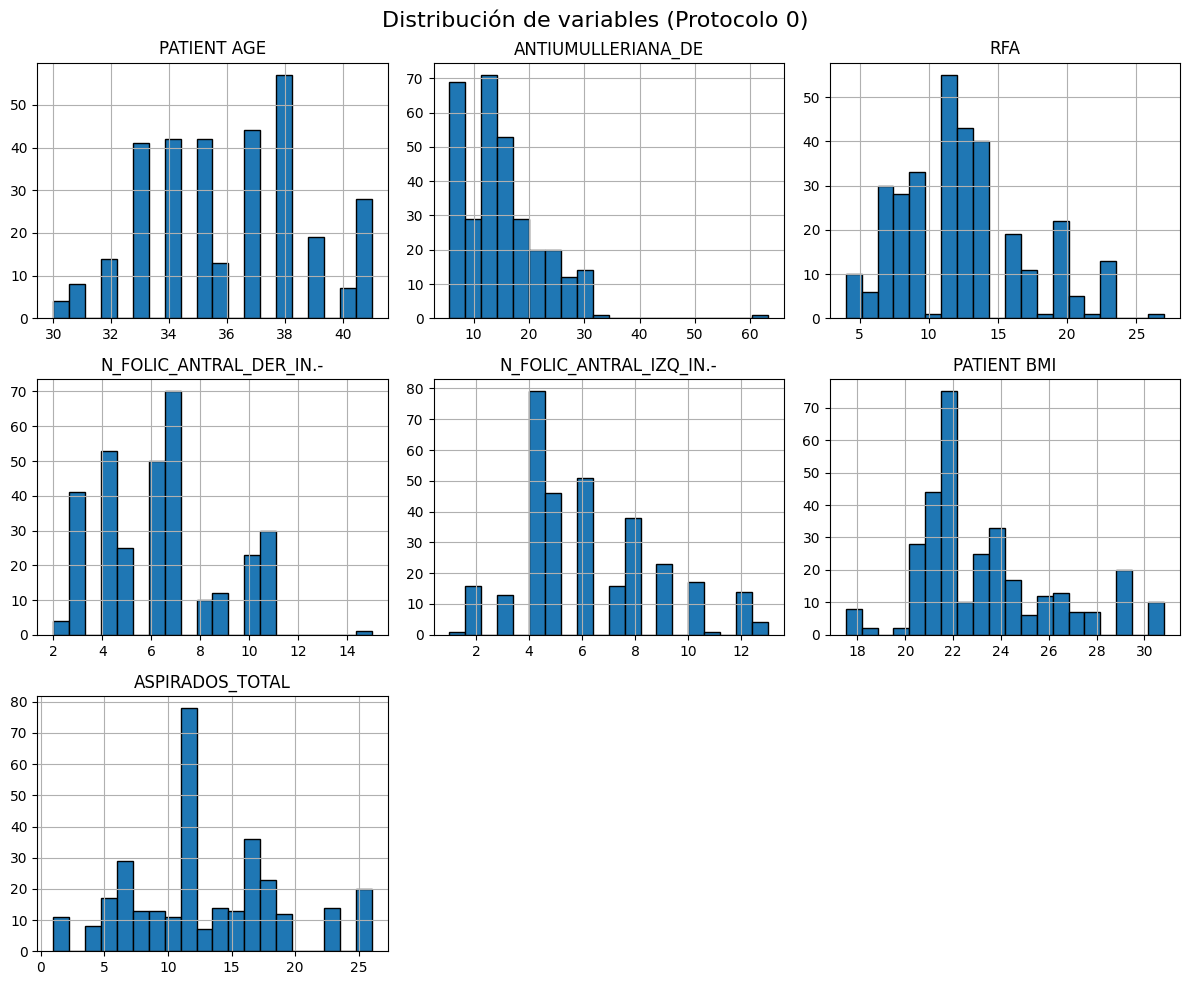

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtrar grupo 0
grupo_0 = data[data['ESTIMULACI√ìN FINAL'] == 0]

# 2. Seleccionar variables cl√≠nicas relevantes
vars_interes = [
    'PATIENT AGE',
    'ANTIUMULLERIANA_DE',
    'RFA',
    'N_FOLIC_ANTRAL_DER_IN.-',
    'N_FOLIC_ANTRAL_IZQ_IN.-',
    'PATIENT BMI',
    'ASPIRADOS_TOTAL'
]

grupo_0 = grupo_0[vars_interes].dropna()

# 3. Estad√≠sticas descriptivas
print("üìå Estad√≠sticas descriptivas del grupo con protocolo 0:\n")
print(grupo_0.describe())

# 4. Histograma para cada variable
grupo_0.hist(bins=20, figsize=(12, 10), edgecolor='black')
plt.suptitle("Distribuci√≥n de variables (Protocolo 0)", fontsize=16)
plt.tight_layout()
plt.show()




In [ ]:
#SOLO NOS NTERESAN LOS 4 ESTIMULOS, ELIMINAMOS POR UNN LADO EL 0 Y EL ESTIMULO QUE ENGLOBA TODO
# Lista de los 4 protocolos que S√ç quieres analizar
protocolos_validos = ['FSH', 'FSH+HMG', 'HMG', 'FSH+LH']

# Filtrar solo esos protocolos
data_filtrada = data[data['ESTIMULACI√ìN FINAL'].isin(protocolos_validos)]
data_filtrada['ESTIMULACI√ìN FINAL'].value_counts()

ESTIMULACI√ìN FINAL
FSH+HMG    22013
FSH         3394
HMG         2716
FSH+LH      1260
Name: count, dtype: int64

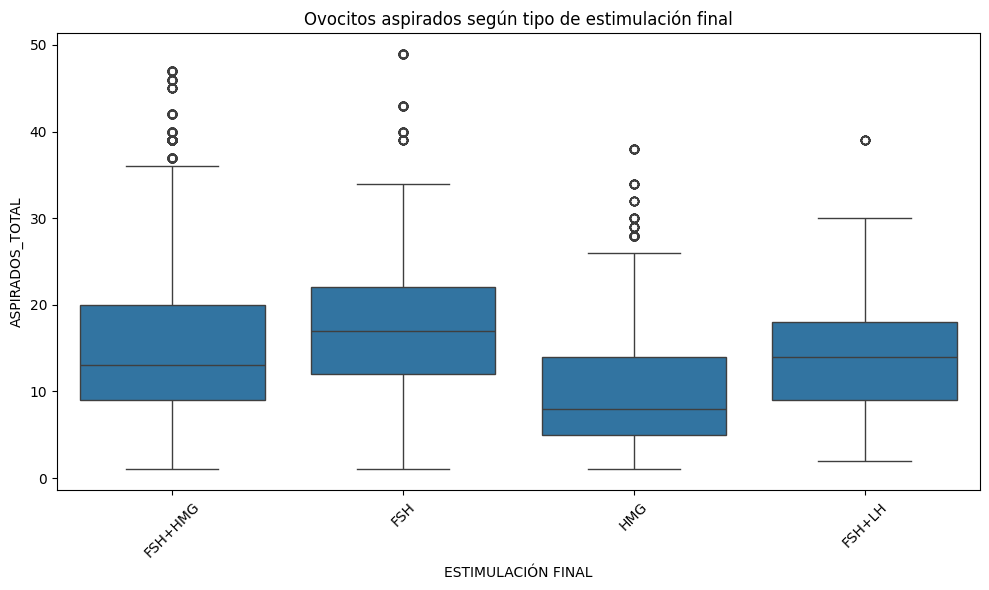

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=data_filtrada, x='ESTIMULACI√ìN FINAL', y='ASPIRADOS_TOTAL')
plt.xticks(rotation=45)
plt.title('Ovocitos aspirados seg√∫n tipo de estimulaci√≥n final')
plt.tight_layout()
plt.show()

Este gr√°fico muestra c√≥mo var√≠a la cantidad de ovocitos aspirados en funci√≥n del protocolo de estimulaci√≥n hormonal utilizado. Cada caja representa un grupo de pacientes que recibi√≥ el mismo tipo de tratamiento, y resume c√≥mo fueron los resultados dentro de ese grupo.

-FSH+HMG. De losprotocolos con mejor respuesta ovar√≠ca
  *   La mediana (l√≠nea dentro de la caja) est√° alta, en torno a 14‚Äì15  
      ovocitos.
  *   La mayor√≠a de pacientes con este protocolo obtuvo entre 10 y 20   
      ovocitos, un rango que consideramos una buena respuesta.
  *   Hay varios outliers por encima, lo que significa que algunas
      pacientes consiguieron incluso m√°s de 30‚Äì35 ovocitos, siendo hiperrespondedoras.

-FSH.
  * El protocolo FSH muestra una muy buena respuesta ov√°rica, con la mediana m√°s alta de todos los grupos, lo que indica que la mitad de las pacientes obtuvo m√°s ovocitos en comparaci√≥n con los dem√°s protocolos.Sin embargo, su rango intercuart√≠lico (la caja) es m√°s peque√±o, lo que significa que la mayor√≠a de las pacientes tuvo resultados m√°s similares entre s√≠, con menor variabilidad.En cambio, FSH+HMG tiene una mediana un poco m√°s baja, pero muestra una mayor dispersi√≥n en las respuestas y m√°s outliers altos, lo que sugiere que algunas pacientes pueden tener una respuesta mucho m√°s intensa, aunque el grupo en general sea m√°s variable

-HMG

  *  En este protocolo observamos que, aunque los resultados no son malos, s√≠ son m√°s limitados en comparaci√≥n con otros tipos de estimulaci√≥n.La mediana es m√°s baja, lo que indica que la mitad de las pacientes obtuvo una cantidad de ovocitos inferior respecto a protocolos como FSH o FSH+HMG.La caja del boxplot es m√°s estrecha, lo que sugiere que las pacientes responden de forma m√°s homog√©nea, es decir, no hay grandes diferencias entre unas y otras.La mayor√≠a de las pacientes obtuvieron entre 5 y 25 ovocitos, lo que indica una respuesta moderada pero estable.Adem√°s, se observan algunos outliers altos, aunque en menor n√∫mero que otros protocolos, lo que refuerza la idea de una respuesta m√°s controlada y menos extrema.Este tipo de protocolo puede utilizarse en pacientes con caracter√≠sticas cl√≠nicas espec√≠ficas, donde se busca una estimulaci√≥n m√°s suave o con menor variabilidad.


-FSH+LH

  *   Este protocolo muestra una respuesta moderadamente buena, con una mediana relativamente alta, lo que indica que la mitad de las pacientes obtuvo una cantidad adecuada de ovocitos.La caja del boxplot tiene un tama√±o intermedio, lo cual sugiere una variedad razonable de respuestas, sin ser tan disperso como FSH+HMG pero tampoco tan homog√©neo como HMG.La mayor√≠a de las pacientes obtuvo entre 8 y 25 ovocitos, lo que refleja una respuesta ov√°rica bastante equilibrada.Se observan algunos outliers altos, lo cual indica que hay pacientes que respondieron muy bien a esta combinaci√≥n hormonal.En resumen, FSH+LH parece ser un protocolo con resultados consistentes y efectivos, que podr√≠a ser √∫til para pacientes con perfil intermedio o que necesitan un peque√±o refuerzo de LH para mejorar su respuesta.

FSH+LH+HMG

  *   ste protocolo presenta la respuesta m√°s baja de todos los grupos analizados.La mediana es visiblemente inferior, y la caja es muy peque√±a, lo que indica que la mayor√≠a de las pacientes tuvo una respuesta baja y bastante similar entre s√≠.La mayor√≠a se sit√∫a entre 4 y 8 ovocitos aspirados, lo que sugiere un uso m√°s frecuente en pacientes con baja reserva ov√°rica o antecedentes de baja respuesta.Pr√°cticamente no hay outliers altos, lo que confirma que este protocolo no genera respuestas muy elevadas, sino que parece estar dise√±ado para pacientes donde se busca una estimulaci√≥n suave o adaptada a una baja capacidad ov√°rica.En resumen, FSH+LH+HMG es un protocolo probablemente usado en casos cl√≠nicos m√°s delicados, y aunque no consigue altas cifras de ovocitos, puede ser adecuado para pacientes con ciertas limitaciones.

CONCLUSION:

  Comparando los protocolos FSH y FSH+HMG, se observa que ambos muestran una respuesta ov√°rica s√≥lida, con medianas altas y rangos de ovocitos bastante amplios.Si bien el protocolo FSH+HMG muestra una mayor variabilidad y m√°s casos con respuestas extremas (outliers altos), la diferencia en la mediana con respecto a FSH no es sustancialmente grande.Esto sugiere que a√±adir HMG al protocolo basado en FSH puede ofrecer una ligera ventaja, especialmente en pacientes que podr√≠an beneficiarse de una estimulaci√≥n m√°s intensa, pero no necesariamente garantiza una mejora significativa para todos los perfiles.Por tanto, ambos protocolos podr√≠an considerarse eficaces, y la elecci√≥n puede depender m√°s del contexto cl√≠nico espec√≠fico de la paciente que de diferencias marcadas en los resultados medios








In [ ]:
# Seleccionamos solo las columnas necesarias para el modelo
cols = [
    "ESTIMULACI√ìN FINAL",
    "PATIENT AGE",
    "PATIENT BMI",
    "Dosis alta (>2500)",
    "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-",
    "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL",
    "RFA",
    "ASPIRADOS_TOTAL"
]

df_model = data_filtrada[cols].copy()


In [ ]:
#ONE HOT ENCODEING
df_dummies=pd.get_dummies(df_model, columns=['ESTIMULACI√ìN FINAL'])

Aqu√≠ seleccionamos las variables cl√≠nicas que, seg√∫n la literatura, afectan la respuesta ov√°rica y, por tanto, la cantidad de ovocitos aspirados.

In [ ]:
df_dummies.head(5)

PATIENT AGE  PATIENT BMI  Dosis alta (>2500)  ANTIUMULLERIANA_DE  \
0           35        24.13                 NaN                 NaN   
1           35        24.13                 NaN                 NaN   
2           35        24.13                 NaN                 NaN   
3           35        24.13                 NaN                 NaN   
4           35        24.13                 NaN                 NaN   

   N_FOLIC_ANTRAL_DER_IN.-  N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL  RFA  \
0                      NaN                      NaN       4100.0  NaN   
1                      NaN                      NaN       4100.0  NaN   
2                      NaN                      NaN       4100.0  NaN   
3                      NaN                      NaN       4100.0  NaN   
4                      NaN                      NaN       4100.0  NaN   

   ASPIRADOS_TOTAL  ESTIMULACI√ìN FINAL_FSH  ESTIMULACI√ìN FINAL_FSH+HMG  \
0             13.0                   False                        True   
1             13.0                   False                        True   
2             13.0                   False                        True   
3             13.0                   False                        True   
4             13.0                   False                        True   

   ESTIMULACI√ìN FINAL_FSH+LH  ESTIMULACI√ìN FINAL_HMG  
0                      False                   False  
1                      False                   False  
2                      False                   False  
3                      False                   False  
4                      False                   False

                         PATIENT AGE  PATIENT BMI  Dosis alta (>2500)  \
PATIENT AGE                 1.000000     0.006715            0.009976   
PATIENT BMI                 0.006715     1.000000            0.098058   
Dosis alta (>2500)          0.009976     0.098058            1.000000   
ANTIUMULLERIANA_DE         -0.233677    -0.023325            0.326389   
N_FOLIC_ANTRAL_DER_IN.-    -0.268548     0.025470            0.257521   
N_FOLIC_ANTRAL_IZQ_IN.-    -0.285623     0.023229            0.157628   
DOSIS TOTAL                 0.262633     0.099921            0.855875   
RFA                        -0.290488     0.027556            0.236714   
ASPIRADOS_TOTAL            -0.254840    -0.012652            0.376561   

                         ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
PATIENT AGE                       -0.233677                -0.268548   
PATIENT BMI                       -0.023325                 0.025470   
Dosis alta (>2500)                 0.326389          

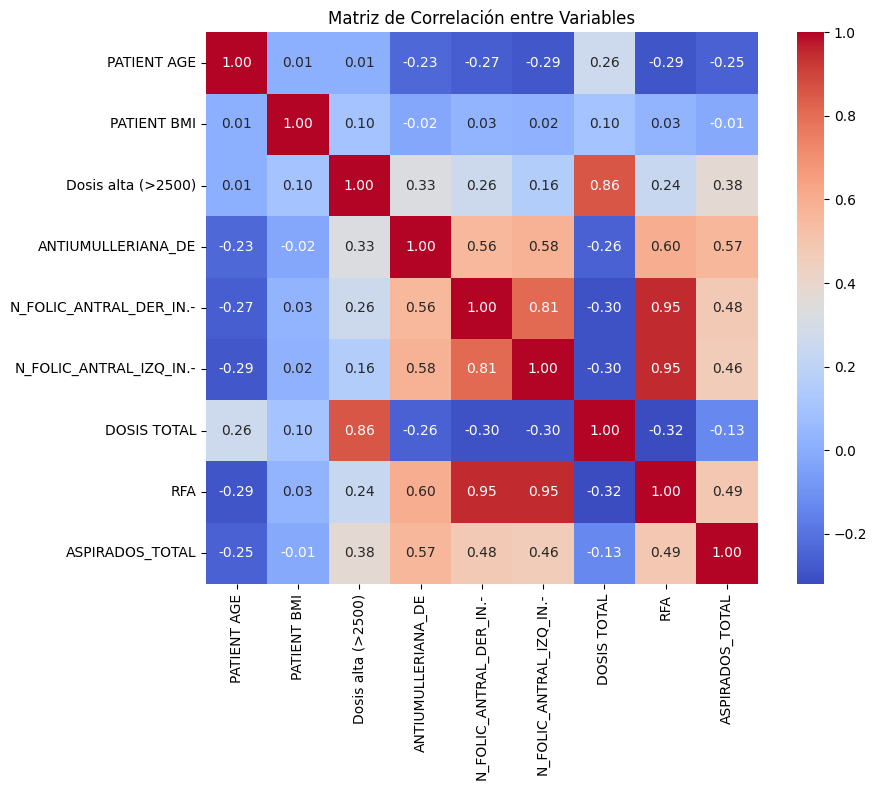

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calcular la matriz de correlaci√≥n (solo variables num√©ricas)
correlation_matrix = df_model.corr(numeric_only=True)
print(correlation_matrix)
# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlaci√≥n entre Variables")
plt.tight_layout()
plt.show()

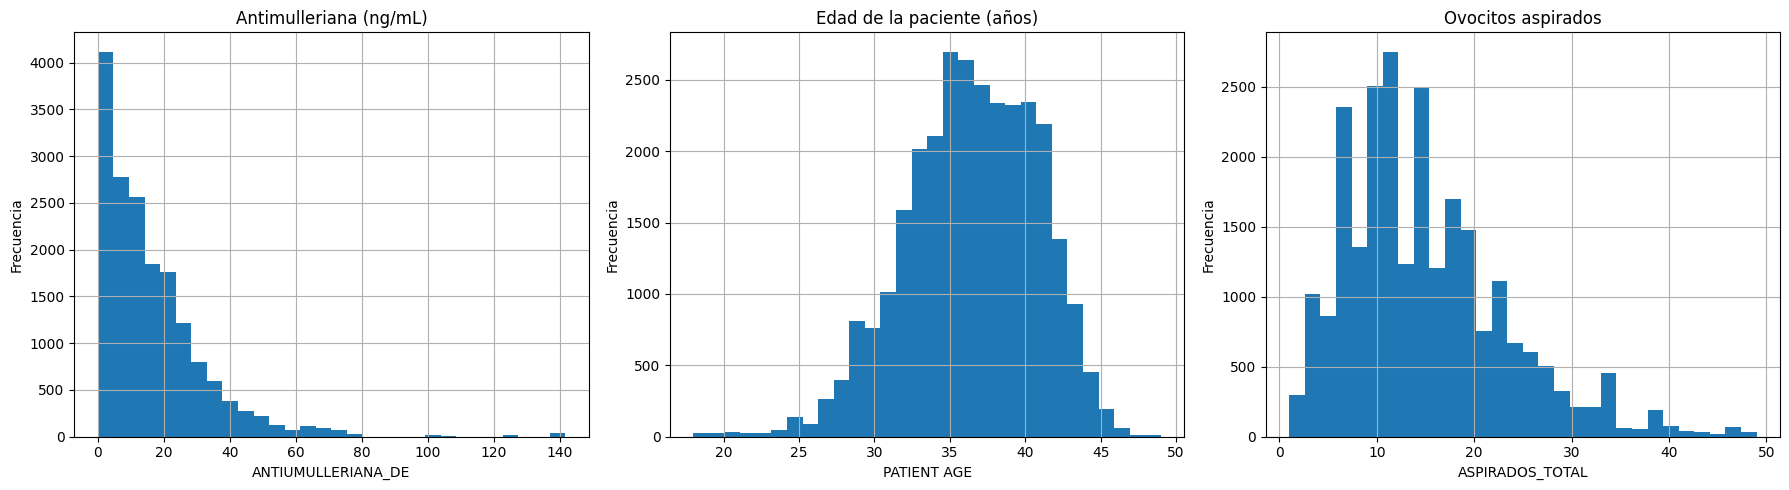

In [ ]:
# Crear histogramas de las 3 variables solicitadas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Variables a graficar
variables = ['ANTIUMULLERIANA_DE', 'PATIENT AGE', 'ASPIRADOS_TOTAL']
titulos = ['Antimulleriana (ng/mL)', 'Edad de la paciente (a√±os)', 'Ovocitos aspirados']

# Crear cada histograma
for ax, var, titulo in zip(axes, variables, titulos):
    df_model[var].dropna().hist(ax=ax, bins=30)
    ax.set_title(titulo)
    ax.set_xlabel(var)
    ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


#
 üìä Exploraci√≥n inicial de variables clave

Se analizan tres variables importantes en el contexto del modelo:
- ANTIUMULLERIANA_DE: marcador de reserva ov√°rica.
- PATIENT AGE: edad de la paciente.
- ASPIRADOS_TOTAL: n√∫mero de ovocitos obtenidos tras punci√≥n.

 El objetivo es entender la distribuci√≥n de estas variables para:
 1. Identificar posibles sesgos o asimetr√≠as.
 2. Evaluar la necesidad de transformaciones (e.g., logar√≠tmica).
 3. Visualizar rangos frecuentes y posibles valores at√≠picos.

 üîç Resultados de los histogramas:

 ‚úîÔ∏è Antimulleriana presenta una distribuci√≥n asim√©trica a la derecha, con alta frecuencia de valores bajos
 y unos pocos valores muy altos. Esto sugiere una posible transformaci√≥n logar√≠tmica si se aplica regresi√≥n lineal.

 ‚úîÔ∏è La edad de las pacientes se distribuye de forma m√°s sim√©trica, centrada alrededor de los 35 a√±os,lo que refleja el perfil t√≠pico de pacientes en tratamientos de fertilidad.

‚úîÔ∏è El n√∫mero de ovocitos aspirados (ASPIRADOS_TOTAL) tambi√©n es asim√©trico, concentrado en torno a 10‚Äì15,pero con una cola hacia valores m√°s altos (hasta 40‚Äì50). Esta variable ser√° nuestra variable objetivo (y) principal.

Estos an√°lisis permiten seleccionar adecuadamente los m√©todos de modelado y decidir si se requieren ajustes
en las variables antes de entrenar los modelos.


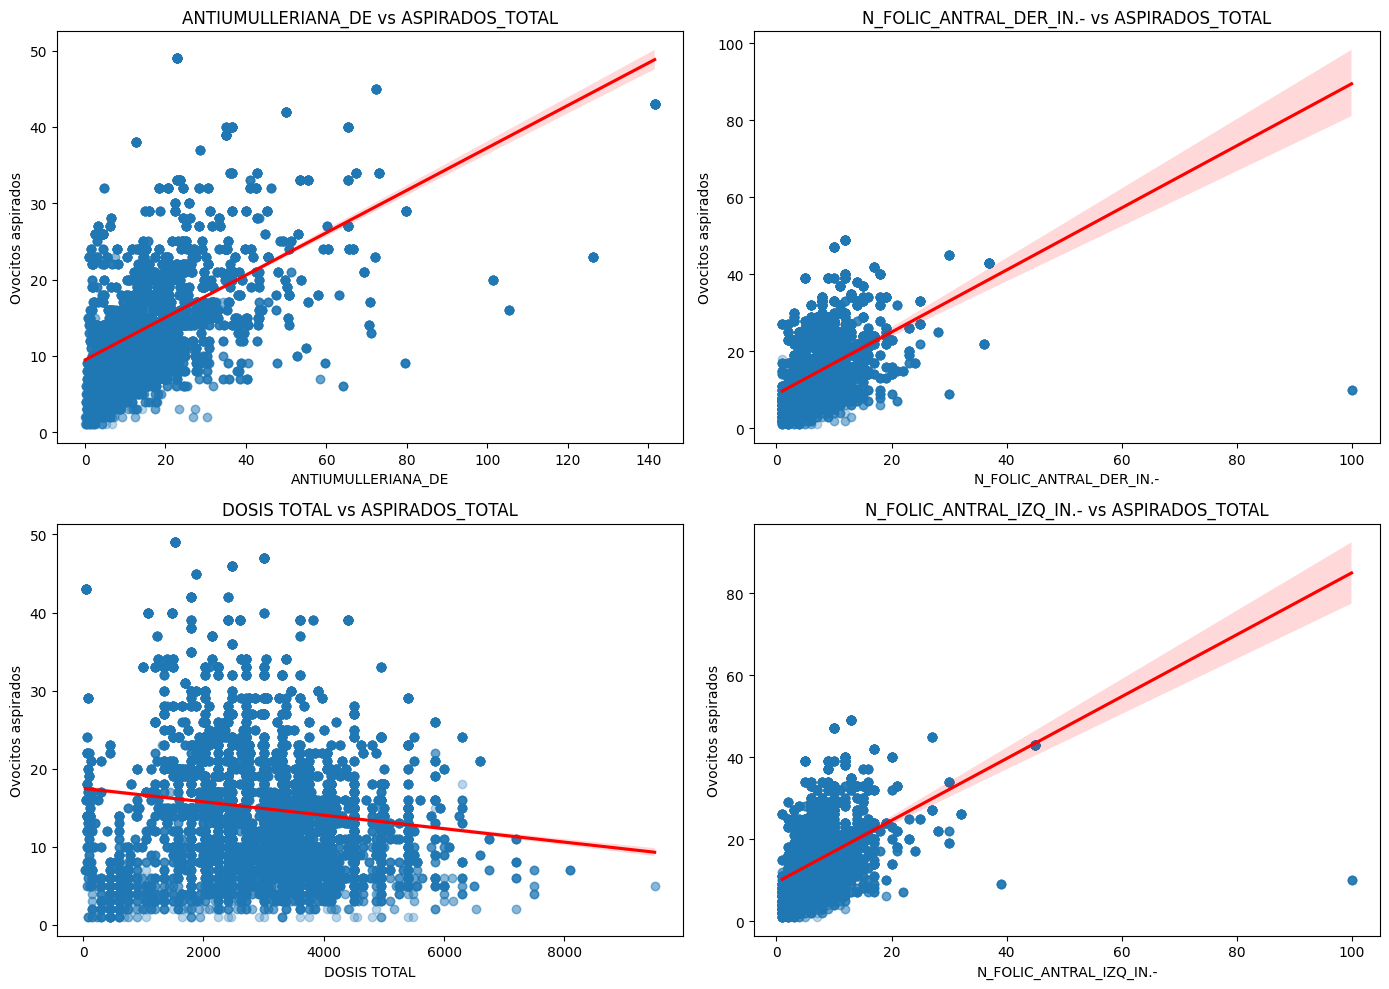

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variables que queremos analizar frente a ASPIRADOS_TOTAL
predictoras = ['ANTIUMULLERIANA_DE', 'N_FOLIC_ANTRAL_DER_IN.-', 'DOSIS TOTAL', 'N_FOLIC_ANTRAL_IZQ_IN.-','Dosis alta (>2500)','PATIENT AGE','ESTIMULACI√ìN FINAL_FSH']
objetivo = 'ASPIRADOS_TOTAL'

# Crear los scatter plots con l√≠nea de regresi√≥n
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, var in zip(axes.flat, predictoras):
    sns.regplot(data=df_model, x=var, y=objetivo, ax=ax, scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
    ax.set_title(f'{var} vs {objetivo}')
    ax.set_xlabel(var)
    ax.set_ylabel('Ovocitos aspirados')

plt.tight_layout()
plt.show()


In [ ]:
#¬øQUE HACER CON LOS NULOS?
df_model.info()
df_model.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 29383 entries, 0 to 31299
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ESTIMULACI√ìN FINAL       29383 non-null  object 
 1   PATIENT AGE              29383 non-null  int64  
 2   PATIENT BMI              27751 non-null  float64
 3   Dosis alta (>2500)       460 non-null    float64
 4   ANTIUMULLERIANA_DE       17145 non-null  float64
 5   N_FOLIC_ANTRAL_DER_IN.-  20581 non-null  float64
 6   N_FOLIC_ANTRAL_IZQ_IN.-  20517 non-null  float64
 7   DOSIS TOTAL              29383 non-null  float64
 8   RFA                      20313 non-null  float64
 9   ASPIRADOS_TOTAL          24729 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.5+ MB


ESTIMULACI√ìN FINAL             0
PATIENT AGE                    0
PATIENT BMI                 1632
Dosis alta (>2500)         28923
ANTIUMULLERIANA_DE         12238
N_FOLIC_ANTRAL_DER_IN.-     8802
N_FOLIC_ANTRAL_IZQ_IN.-     8866
DOSIS TOTAL                    0
RFA                         9070
ASPIRADOS_TOTAL             4654
dtype: int64

In [ ]:
df_model['Dosis_alta_reconstruida'] = (df_model['DOSIS TOTAL'] > 2500).astype(int)


In [ ]:
#Ligera correlacion pero puede ser valiosa
df_model[['Dosis_alta_reconstruida', 'ASPIRADOS_TOTAL']].corr()


Dosis_alta_reconstruida  ASPIRADOS_TOTAL
Dosis_alta_reconstruida                 1.000000        -0.159651
ASPIRADOS_TOTAL                        -0.159651         1.000000

In [ ]:
# Eliminar filas sin variable objetivo (importante)
df_model = df_model.dropna(subset=['ASPIRADOS_TOTAL'])

# Rellenar con la mediana las variables importantes
cols_rellenar = [
    'PATIENT BMI',
    'ANTIUMULLERIANA_DE',
    'N_FOLIC_ANTRAL_DER_IN.-',
    'N_FOLIC_ANTRAL_IZQ_IN.-',
    'DOSIS TOTAL',
    'RFA'
]

df_model[cols_rellenar] = df_model[cols_rellenar].fillna(df_model[cols_rellenar].median())


<ipython-input-20-6c16949d518d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[cols_rellenar] = df_model[cols_rellenar].fillna(df_model[cols_rellenar].median())


In [ ]:
df_model=df_model.drop(columns=['Dosis alta (>2500)'])

In [ ]:
df_model.info()
df_model.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 24729 entries, 0 to 26796
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ESTIMULACI√ìN FINAL       24729 non-null  object 
 1   PATIENT AGE              24729 non-null  int64  
 2   PATIENT BMI              24729 non-null  float64
 3   ANTIUMULLERIANA_DE       24729 non-null  float64
 4   N_FOLIC_ANTRAL_DER_IN.-  24729 non-null  float64
 5   N_FOLIC_ANTRAL_IZQ_IN.-  24729 non-null  float64
 6   DOSIS TOTAL              24729 non-null  float64
 7   RFA                      24729 non-null  float64
 8   ASPIRADOS_TOTAL          24729 non-null  float64
 9   Dosis_alta_reconstruida  24729 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 2.1+ MB


ESTIMULACI√ìN FINAL         0
PATIENT AGE                0
PATIENT BMI                0
ANTIUMULLERIANA_DE         0
N_FOLIC_ANTRAL_DER_IN.-    0
N_FOLIC_ANTRAL_IZQ_IN.-    0
DOSIS TOTAL                0
RFA                        0
ASPIRADOS_TOTAL            0
Dosis_alta_reconstruida    0
dtype: int64

In [ ]:
df_model.head(5)

ESTIMULACI√ìN FINAL  PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  \
0            FSH+HMG           35        24.13               14.52   
1            FSH+HMG           35        24.13               14.52   
2            FSH+HMG           35        24.13               14.52   
3            FSH+HMG           35        24.13               14.52   
4            FSH+HMG           35        24.13               14.52   

   N_FOLIC_ANTRAL_DER_IN.-  N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL   RFA  \
0                      7.0                      6.0       4100.0  13.0   
1                      7.0                      6.0       4100.0  13.0   
2                      7.0                      6.0       4100.0  13.0   
3                      7.0                      6.0       4100.0  13.0   
4                      7.0                      6.0       4100.0  13.0   

   ASPIRADOS_TOTAL  Dosis_alta_reconstruida  
0             13.0                        1  
1             13.0                        1  
2             13.0                        1  
3             13.0                        1  
4             13.0                        1

In [ ]:
df_model=pd.get_dummies(df_model, columns=['ESTIMULACI√ìN FINAL'])

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df_model.drop(columns=["ASPIRADOS_TOTAL"])
y = df_model["ASPIRADOS_TOTAL"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Lista de modelos a comparar
modelos = {
    "Regresi√≥n Lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Red Neuronal (MLP)": MLPRegressor(random_state=42, max_iter=500)
}

# 3. Evaluar cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{nombre}:\n  MAE = {mae:.2f}\n  RMSE = {rmse:.2f}\n  R¬≤ = {r2:.2f}\n")


Regresi√≥n Lineal:
  MAE = 5.30
  RMSE = 6.92
  R¬≤ = 0.29

Random Forest:
  MAE = 0.20
  RMSE = 0.82
  R¬≤ = 0.99

Gradient Boosting:
  MAE = 4.51
  RMSE = 5.86
  R¬≤ = 0.49

Red Neuronal (MLP):
  MAE = 4.15
  RMSE = 5.42
  R¬≤ = 0.56



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Como ya sabemos estas son las metricas que tenemos que tener en cuenta para elegir un modelo de predicci√≥n:

  * MAE(mean absolut Error):Diferncia entre el valor real y los predichos.
  cuanto  menor sea mejor.
  * RMSE(Ra√≠z del Error Cuadr√°tico Medio):Similar al MAE, pero penaliza m√°s los errores grandes.
  * R2:Mide qu√© porcentaje de la variabilidad del objetivo (ASPIRADOS_TOTAL) explica el modelo.Va de 0 (explica nada) a 1 (explica todo).
  
Por ende el mejor resultado es el Random Forest


In [ ]:
#Revisamos que no hay overfifting ya que el R2 es muy bueno
y_train_pred = modelo.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"R¬≤ en entrenamiento: {r2_train:.2f}")


R¬≤ en entrenamiento: 0.59


In [ ]:
#Vemos que es mas bajo, raro porque deberia ser al reves no tan bueno en el test u mejor en el train.Posible causa division de los datos favorable
#Por eso validacion criuzada
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

modelo = RandomForestRegressor(random_state=42)
scores = cross_val_score(modelo, X_scaled, y, cv=5, scoring='r2')

print("R¬≤ por fold:", scores)
print("R¬≤ medio (validaci√≥n cruzada):", np.mean(scores))


R¬≤ por fold: [0.1355467  0.11366633 0.11747039 0.21243317 0.04589796]
R¬≤ medio (validaci√≥n cruzada): 0.12500290970867806


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,             # limitar profundidad
    min_samples_leaf=10,     # evitar ramas peque√±as
    random_state=42
)

scores = cross_val_score(modelo_rf, X_scaled, y, cv=5, scoring='r2')
print("R¬≤ por fold:", scores)
print("R¬≤ medio:", np.mean(scores))


R¬≤ por fold: [0.26021992 0.20652076 0.26894023 0.37920782 0.22924881]
R¬≤ medio: 0.2688275074491246


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

modelo_gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

scores_gb = cross_val_score(modelo_gb, X_scaled, y, cv=5, scoring='r2')
print("R¬≤ por fold (GB):", scores_gb)
print("R¬≤ medio (GB):", np.mean(scores_gb))


R¬≤ por fold (GB): [0.20170077 0.15804469 0.25700127 0.33842911 0.1982477 ]
R¬≤ medio (GB): 0.23068470837469865


Puede ser que haya mucho ruido vamos a ver


                            PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  \
PATIENT AGE                    1.000000     0.017210           -0.216832   
PATIENT BMI                    0.017210     1.000000            0.011573   
ANTIUMULLERIANA_DE            -0.216832     0.011573            1.000000   
N_FOLIC_ANTRAL_DER_IN.-       -0.227567     0.029953            0.469669   
N_FOLIC_ANTRAL_IZQ_IN.-       -0.238342     0.022382            0.478716   
DOSIS TOTAL                    0.257313     0.096294           -0.238443   
RFA                           -0.241821     0.029064            0.497496   
ASPIRADOS_TOTAL               -0.254840    -0.011711            0.408646   
Dosis_alta_reconstruida        0.269824     0.098811           -0.230109   
ESTIMULACI√ìN FINAL_FSH        -0.323571    -0.025179            0.269963   
ESTIMULACI√ìN FINAL_FSH+HMG     0.147408     0.038452           -0.108507   
ESTIMULACI√ìN FINAL_FSH+LH      0.042492    -0.011334           -0.040730   
ESTIMULAC

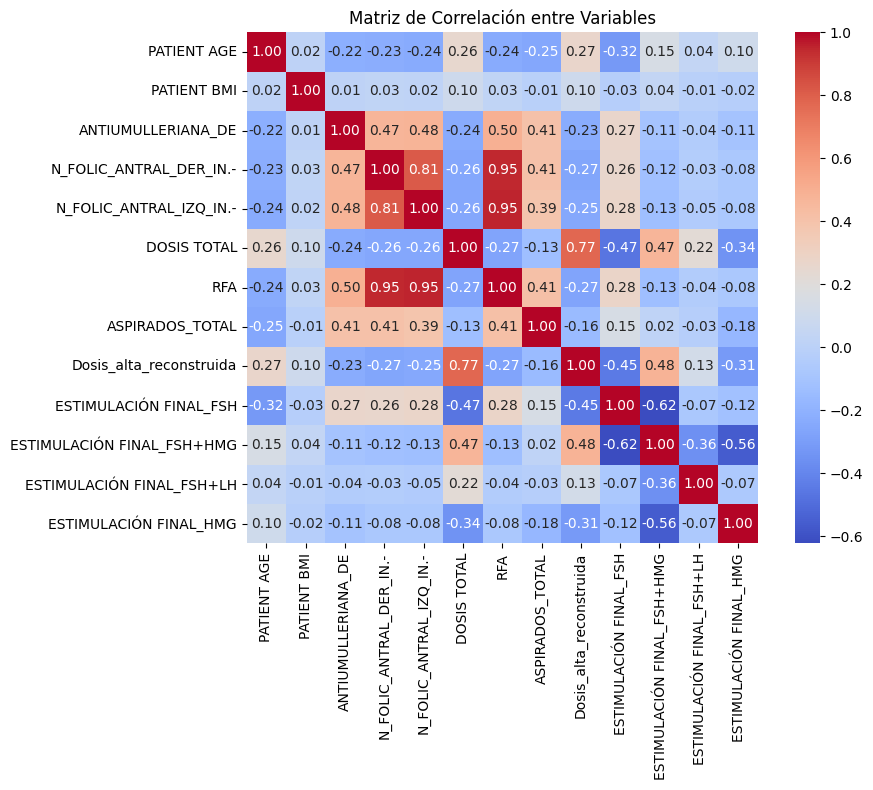

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calcular la matriz de correlaci√≥n (solo variables num√©ricas)
correlation_matrix = df_model.corr(numeric_only=True)
print(correlation_matrix)
# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlaci√≥n entre Variables")
plt.tight_layout()
plt.show()

In [ ]:
# Tras entrenar tu modelo
modelo.fit(X_train, y_train)

# Importancia de cada variable
importancias = modelo.feature_importances_
for nombre, importancia in zip(X.columns, importancias):
    print(f"{nombre}: {importancia:.3f}")


PATIENT AGE: 0.136
PATIENT BMI: 0.191
ANTIUMULLERIANA_DE: 0.193
N_FOLIC_ANTRAL_DER_IN.-: 0.040
N_FOLIC_ANTRAL_IZQ_IN.-: 0.035
DOSIS TOTAL: 0.141
RFA: 0.232
Dosis_alta_reconstruida: 0.006
ESTIMULACI√ìN FINAL_FSH: 0.005
ESTIMULACI√ìN FINAL_FSH+HMG: 0.008
ESTIMULACI√ìN FINAL_FSH+LH: 0.003
ESTIMULACI√ìN FINAL_HMG: 0.010


In [ ]:
#pUEDE QUE ONE-HOT NO NOS ESTE AYUDANDO
# Codificamos la columna como categor√≠a num√©rica
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_filtrada['ESTIMULACI√ìN FINAL COD'] = le.fit_transform(data_filtrada['ESTIMULACI√ìN FINAL'])

# Luego actualizas tu df_model incluyendo esta nueva columna
cols = [
    "PATIENT AGE",
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-",
    "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL",
    "RFA",
    "ESTIMULACI√ìN FINAL COD",
    "ASPIRADOS_TOTAL"
]

df_model = data_filtrada[cols].copy()




<ipython-input-8-ed2e02e600b6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrada['ESTIMULACI√ìN FINAL COD'] = le.fit_transform(data_filtrada['ESTIMULACI√ìN FINAL'])


In [ ]:
# Eliminar filas sin variable objetivo (importante)
df_model = df_model.dropna(subset=['ASPIRADOS_TOTAL'])

# Rellenar con la mediana las variables importantes
cols_rellenar = [
    'PATIENT BMI',
    'ANTIUMULLERIANA_DE',
    'N_FOLIC_ANTRAL_DER_IN.-',
    'N_FOLIC_ANTRAL_IZQ_IN.-',
    'DOSIS TOTAL',
    'RFA'
]

df_model[cols_rellenar] = df_model[cols_rellenar].fillna(df_model[cols_rellenar].median())

In [ ]:
df_model.head(5)

PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
0           35        24.13               14.52                      7.0   
1           35        24.13               14.52                      7.0   
2           35        24.13               14.52                      7.0   
3           35        24.13               14.52                      7.0   
4           35        24.13               14.52                      7.0   

   N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL   RFA  ESTIMULACI√ìN FINAL COD  \
0                      6.0       4100.0  13.0                       1   
1                      6.0       4100.0  13.0                       1   
2                      6.0       4100.0  13.0                       1   
3                      6.0       4100.0  13.0                       1   
4                      6.0       4100.0  13.0                       1   

   ASPIRADOS_TOTAL  
0             13.0  
1             13.0  
2             13.0  
3             13.0  
4             13.0

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df_model.drop(columns=["ASPIRADOS_TOTAL"])
y = df_model["ASPIRADOS_TOTAL"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#Revisamos que no hay overfifting ya que el R2 es muy bueno
y_train_pred = modelo.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"R¬≤ en entrenamiento: {r2_train:.2f}")

R¬≤ en entrenamiento: 1.00


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Crear el modelo
modelo = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Evaluaci√≥n con validaci√≥n cruzada (5-fold)
scores = cross_val_score(modelo, X_scaled, y, cv=5, scoring='r2')

# Mostrar los resultados
print("R¬≤ por fold:", scores)
print("R¬≤ medio (validaci√≥n cruzada):", np.mean(scores))



R¬≤ por fold: [0.19353881 0.17230454 0.25178234 0.32683294 0.1918594 ]
R¬≤ medio (validaci√≥n cruzada): 0.2272636074395426


In [ ]:
"""
cols = [
    "PATIENT AGE",
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-",
    "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL",
    "RFA",
    "ESTIMULACI√ìN FINAL COD",
    "dias_estim_e_cl.-",
    "P4_DHCG_DE.-",
    "NIVEL_FSH_H_DE.-_OK",
    "ULT_LIN_ENDOM",
    "ampollas_fsh_e_cl.-",
    "ampollas_lh_e_cl.-",
    "ASPIRADOS_TOTAL"
]

df_model = data_filtrada[cols].copy()

# Limpieza r√°pida
df_model1= df_model.dropna(subset=["ASPIRADOS_TOTAL"])  # nunca imputar el target
df_model1 = df_model1.fillna(df_model.median(numeric_only=True))  # imputar predictoras
"""

'\ncols = [\n    "PATIENT AGE",\n    "PATIENT BMI",\n    "ANTIUMULLERIANA_DE",\n    "N_FOLIC_ANTRAL_DER_IN.-",\n    "N_FOLIC_ANTRAL_IZQ_IN.-",\n    "DOSIS TOTAL",\n    "RFA",\n    "ESTIMULACI√ìN FINAL COD",\n    "dias_estim_e_cl.-",\n    "P4_DHCG_DE.-",\n    "NIVEL_FSH_H_DE.-_OK",\n    "ULT_LIN_ENDOM",\n    "ampollas_fsh_e_cl.-",\n    "ampollas_lh_e_cl.-",\n    "ASPIRADOS_TOTAL"\n]\n\ndf_model = data_filtrada[cols].copy()\n\n# Limpieza r√°pida\ndf_model1= df_model.dropna(subset=["ASPIRADOS_TOTAL"])  # nunca imputar el target\ndf_model1 = df_model1.fillna(df_model.median(numeric_only=True))  # imputar predictoras\n'

In [ ]:
#df_model1.head(20)

In [ ]:
cols = [
    "PATIENT AGE",
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-",
    "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL",
    "RFA",
    "ESTIMULACI√ìN FINAL COD",
    "dias_estim_e_cl.-",
    "P4_DHCG_DE.-",
    "NIVEL_FSH_H_DE.-_OK",
    "ULT_LIN_ENDOM",
    "ampollas_fsh_e_cl.-",
    "ampollas_lh_e_cl.-",
    "ASPIRADOS_TOTAL"
]

df_model_agrupacion = data_filtrada[cols].copy()



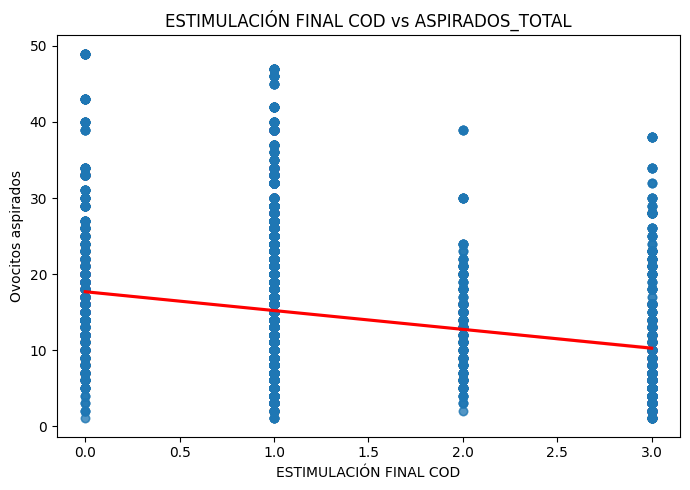

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

predictoras = ['ESTIMULACI√ìN FINAL COD']
objetivo = 'ASPIRADOS_TOTAL'

# Como solo hay una variable, se puede crear una √∫nica figura directamente
plt.figure(figsize=(7, 5))
sns.regplot(data=df_model, x=predictoras[0], y=objetivo,
            scatter_kws={'alpha': 0.3}, line_kws={"color": "red"})
plt.title(f'{predictoras[0]} vs {objetivo}')
plt.xlabel(predictoras[0])
plt.ylabel('Ovocitos aspirados')
plt.tight_layout()
plt.show()


In [ ]:
df_model_agrupacion= df_model_agrupacion.dropna(subset=["ASPIRADOS_TOTAL"])  # nunca imputar el target
df_model_agrupacion = df_model_agrupacion.fillna(df_model.median(numeric_only=True))  # imputar predictoras

In [ ]:
"""def clasificar_ovocitos(n):
    if n < 6:
        return "Bajo"
    elif n <= 15:
        return "Medio"
    else:
        return "Alto"

df_model_agrupacion["ASPIRADOS_GRUPO"] = df_model_agrupacion["ASPIRADOS_TOTAL"].apply(clasificar_ovocitos)
"""

'def clasificar_ovocitos(n):\n    if n < 6:\n        return "Bajo"\n    elif n <= 15:\n        return "Medio"\n    else:\n        return "Alto"\n\ndf_model_agrupacion["ASPIRADOS_GRUPO"] = df_model_agrupacion["ASPIRADOS_TOTAL"].apply(clasificar_ovocitos)\n'

urante el ajuste del modelo de clasificaci√≥n, se configuraron varios hiperpar√°metros del RandomForestClassifier con el objetivo de mejorar su capacidad predictiva y evitar el sobreajuste. A continuaci√≥n se describen los principales:

n_estimators: n√∫mero de √°rboles en el bosque. Un mayor n√∫mero de √°rboles suele mejorar la estabilidad y precisi√≥n del modelo. Se us√≥ un valor de 300 para obtener mayor robustez sin comprometer el tiempo de c√≥mputo.

max_depth: profundidad m√°xima de cada √°rbol. Este par√°metro controla la complejidad del modelo. Se limit√≥ a 8 niveles para evitar sobreajuste y mantener interpretabilidad.

min_samples_split: n√∫mero m√≠nimo de muestras necesarias para dividir un nodo. Se fij√≥ en 10, lo que obliga al modelo a generar ramas m√°s generales y evita divisiones sobre grupos muy peque√±os.

min_samples_leaf: n√∫mero m√≠nimo de muestras en una hoja (nodo final). Se estableci√≥ en 5 para prevenir ramas que representen √∫nicamente casos individuales.

max_features: n√∫mero de variables que se consideran al dividir cada nodo. Se utiliz√≥ "sqrt", que es el valor recomendado para clasificaci√≥n y ayuda a reducir la varianza.

class_weight: se estableci√≥ como "balanced" para corregir el desbalance natural entre clases ("Bajo", "Medio" y "Alto") en el conjunto de datos. Esto fuerza al modelo a prestar m√°s atenci√≥n a las clases menos representadas.

In [ ]:
#df_model_agrupacion["ASPIRADOS_GRUPO"].value_counts(normalize=True)

In [ ]:
"""
uts = pd.qcut(df_model_agrupacion["ASPIRADOS_TOTAL"], q=3, retbins=True)[1]
print(cuts)
"""

'\nuts = pd.qcut(df_model_agrupacion["ASPIRADOS_TOTAL"], q=3, retbins=True)[1]\nprint(cuts)\n'

Como podemos ver los rangos on
    -Bajo 1 a 10
    -Medio 10 a 17
    -Alto 17 a 40

In [ ]:
df_model_agrupacion.head(10)

PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
0           35        24.13               14.52                      7.0   
1           35        24.13               14.52                      7.0   
2           35        24.13               14.52                      7.0   
3           35        24.13               14.52                      7.0   
4           35        24.13               14.52                      7.0   
5           35        24.13               14.52                      7.0   
6           35        24.13               14.52                      7.0   
7           35        24.13               14.52                      7.0   
8           36        25.39               14.52                      7.0   
9           30        19.92               14.52                      8.0   

   N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL   RFA  ESTIMULACI√ìN FINAL COD  \
0                      6.0       4100.0  13.0                       1   
1                      6.0       4100.0  13.0                       1   
2                      6.0       4100.0  13.0                       1   
3                      6.0       4100.0  13.0                       1   
4                      6.0       4100.0  13.0                       1   
5                      6.0       4100.0  13.0                       1   
6                      6.0       4100.0  13.0                       1   
7                      6.0       4100.0  13.0                       1   
8                      6.0       4875.0  13.0                       1   
9                      8.0       1575.0  16.0                       1   

   dias_estim_e_cl.-  P4_DHCG_DE.-  NIVEL_FSH_H_DE.-_OK  ULT_LIN_ENDOM  \
0               15.0          1.40                  0.0            6.0   
1               15.0          1.40                  0.0            6.0   
2               15.0          1.40                  0.0            6.0   
3               15.0          1.40                  0.0            6.0   
4               15.0          1.40                  0.0            6.0   
5               15.0          1.40                  0.0            6.0   
6               15.0          1.40                  0.0            6.0   
7               15.0          1.40                  0.0            6.0   
8               14.0           NaN                  0.0           13.7   
9               10.0          1.85                  0.0            5.0   

   ampollas_fsh_e_cl.-  ampollas_lh_e_cl.-  ASPIRADOS_TOTAL  
0               2700.0                 NaN             13.0  
1               2700.0                 NaN             13.0  
2               2700.0                 NaN             13.0  
3               2700.0                 NaN             13.0  
4               2700.0                 NaN             13.0  
5               2700.0                 NaN             13.0  
6               2700.0                 NaN             13.0  
7               2700.0                 NaN             13.0  
8               3900.0                 NaN              2.0  
9                900.0                 NaN             17.0

In [ ]:
X_OVOCTIOS = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"])
y_class = df_model_agrupacion["ASPIRADOS_TOTAL"]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_OVOCITOS = scaler.fit_transform(X_OVOCTIOS)


In [ ]:
#Aplicar grid search para saber que parametros hay que usar
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
rf=RandomForestClassifier(random_state=42)
param_dist={

    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(5, 20),
    'min_samples_leaf': randint(2, 10),
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']

}
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,  # n¬∫ de combinaciones a probar
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1  # usa todos los n√∫cleos
)

# Entrenamos la b√∫squeda
random_search.fit(X_scaled_OVOCITOS, y_class)

# Mostramos los mejores par√°metros encontrados
print("Mejores par√°metros encontrados:")
print(random_search.best_params_)

# Y la mejor accuracy obtenida
print(f"Mejor accuracy obtenido: {random_search.best_score_:.2f}")


KeyboardInterrupt: 

PROBAMOS OTRO MODELO CON LA INTENCION DE MEJORAR LA ACCURACY

In [ ]:
pip install catboost


In [ ]:
"""
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1. Selecci√≥n de variables y target
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL", "ASPIRADOS_GRUPO"])
y = df_model_agrupacion["ASPIRADOS_GRUPO"]

# 2. Identificamos columnas categ√≥ricas (si hay)
cat_features = [i for i, col in enumerate(X.columns) if 'ESTIMULACI√ìN FINAL' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Crear modelo CatBoost
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=cat_features,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=3,
    task_type="GPU",
    bagging_temperature=1.0
)

# 5. Entrenar
model.fit(X_train, y_train)

# 6. Evaluar
y_pred = model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
"""

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1. Selecci√≥n de variables y target
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL", "ASPIRADOS_GRUPO"])
y = df_model_agrupacion["ASPIRADOS_TOTAL"]

# 2. Identificamos columnas categ√≥ricas (si hay)
cat_features = [i for i, col in enumerate(X.columns) if 'ESTIMULACI√ìN FINAL' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Crear modelo CatBoost
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.01,
    depth=9,
    loss_function='MAE',
    eval_metric='RMSE',
    cat_features=cat_features,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=3,
    task_type="GPU",
    bagging_temperature=1.0
)

# 5. Entrenar
model.fit(X_train, y_train)

# 6. Evaluar
y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred))



-PARAMETROS



En el modelo XGBoostRegressor que has utilizado, cada par√°metro
cumple una funci√≥n clave para mejorar el rendimiento: n_estimators=500 indica que el modelo entrena hasta 500 √°rboles secuenciales, permitiendo un aprendizaje profundo y detallado; learning_rate=0.05 controla la velocidad con la que el modelo ajusta los errores en cada iteraci√≥n, siendo un valor moderado que favorece una convergencia estable y evita sobreajuste; max_depth=6 limita la profundidad de cada √°rbol, equilibrando la capacidad de aprendizaje con la generalizaci√≥n; subsample=0.8 fuerza al modelo a usar solo el 80‚ÄØ% de los datos en cada iteraci√≥n, lo que introduce aleatoriedad y reduce el riesgo de sobreentrenamiento; y colsample_bytree=0.8 selecciona aleatoriamente el 80‚ÄØ% de las variables para cada √°rbol, lo cual mejora la robustez del modelo ante variables redundantes o poco informativas.






¬øPQ ESTE HA FUNCIONADO MEJOR QQUE ELL CASTBOOST?


Aunque  CatBoostRegressor es muy potente y por eso se ha puesto como primera opcion debido aq que necesita mas ajuste en sus parametros no nos ha ofrevcido un buen resultado mientras que XGBoost gracias a parametros como subsample y colsample_bytree han conseguido entender mejor los datos

In [ ]:
pip install -U scikit-learn


In [ ]:
# Rellenar con la mediana para columnas con muchos nulos
df_model_agrupacion["P4_DHCG_DE.-"] = df_model_agrupacion["P4_DHCG_DE.-"].fillna(df_model_agrupacion["P4_DHCG_DE.-"].median())
df_model_agrupacion["NIVEL_FSH_H_DE.-_OK"] = df_model_agrupacion["NIVEL_FSH_H_DE.-_OK"].fillna(df_model_agrupacion["NIVEL_FSH_H_DE.-_OK"].median())
df_model_agrupacion["ULT_LIN_ENDOM"] = df_model_agrupacion["ULT_LIN_ENDOM"].fillna(df_model_agrupacion["ULT_LIN_ENDOM"].median())
df_model_agrupacion["ampollas_fsh_e_cl.-"] = df_model_agrupacion["ampollas_fsh_e_cl.-"].fillna(df_model_agrupacion["ampollas_fsh_e_cl.-"].median())
df_model_agrupacion["ampollas_lh_e_cl.-"] = df_model_agrupacion["ampollas_lh_e_cl.-"].fillna(df_model_agrupacion["ampollas_lh_e_cl.-"].median())


In [ ]:
df_model_agrupacion.isnull().sum()

PATIENT AGE                0
PATIENT BMI                0
ANTIUMULLERIANA_DE         0
N_FOLIC_ANTRAL_DER_IN.-    0
N_FOLIC_ANTRAL_IZQ_IN.-    0
DOSIS TOTAL                0
RFA                        0
ESTIMULACI√ìN FINAL COD     0
dias_estim_e_cl.-          0
P4_DHCG_DE.-               0
NIVEL_FSH_H_DE.-_OK        0
ULT_LIN_ENDOM              0
ampollas_fsh_e_cl.-        0
ampollas_lh_e_cl.-         0
ASPIRADOS_TOTAL            0
dtype: int64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoin
# 1. Selecci√≥n de variables y target
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"])
y = df_model_agrupacion["ASPIRADOS_TOTAL"]

# 2. Codificar variables categ√≥ricas (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. Divisi√≥n en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

evals_result = {}
# 4. Definir y entrenar el modelo
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='gpu_hist',
    eval_metric="mae",
    early_stopping_rounds=10 # o 'gpu_hist' si tienes GPU
)
# Guardar el mejor modelo seg√∫n la validaci√≥n
checkpoint = ModelCheckpoint('model_xgbRegressor_aspirados_checkpoint.h5', monitor='val_loss', save_best_only=True, mode='min')

model.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
            # stop if RMSE doesn't improve for 10 rounds
          verbose=True,
         )


# 5. Evaluar el modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R¬≤:   {r2:.4f}")


KeyboardInterrupt: 

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import pickle
# 1. Selecci√≥n de variables y target
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"])
y = df_model_agrupacion["ASPIRADOS_TOTAL"]

# 2. Codificar variables categ√≥ricas (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. Divisi√≥n en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

evals_result = {}
# 4. Definir y entrenar el modelo
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    eval_metric="rmse",
    early_stopping_rounds=10 # o 'gpu_hist' si tienes GPU
)

model.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
            # stop if RMSE doesn't improve for 10 rounds
          verbose=True,
         )


# 5. Evaluar el modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R¬≤:   {r2:.4f}")

with open("modelo_xgb_residuos.pkl", "wb") as archivo:
    pickle.dump(model, archivo)

print("‚úÖ Modelo guardado exitosamente en modelo_xgb_residuos.pkl")

[0]	validation_0-rmse:8.08343	validation_1-rmse:8.03064
[1]	validation_0-rmse:7.92863	validation_1-rmse:7.87562
[2]	validation_0-rmse:7.75746	validation_1-rmse:7.70175
[3]	validation_0-rmse:7.60193	validation_1-rmse:7.54748
[4]	validation_0-rmse:7.45141	validation_1-rmse:7.39405
[5]	validation_0-rmse:7.30932	validation_1-rmse:7.25654
[6]	validation_0-rmse:7.17560	validation_1-rmse:7.12265
[7]	validation_0-rmse:7.05174	validation_1-rmse:7.00093
[8]	validation_0-rmse:6.93698	validation_1-rmse:6.88320
[9]	validation_0-rmse:6.81271	validation_1-rmse:6.75731
[10]	validation_0-rmse:6.70667	validation_1-rmse:6.65509
[11]	validation_0-rmse:6.60144	validation_1-rmse:6.55048
[12]	validation_0-rmse:6.49782	validation_1-rmse:6.45458
[13]	validation_0-rmse:6.40921	validation_1-rmse:6.36723
[14]	validation_0-rmse:6.31810	validation_1-rmse:6.27872
[15]	validation_0-rmse:6.23586	validation_1-rmse:6.19970
[16]	validation_0-rmse:6.16165	validation_1-rmse:6.12486
[17]	validation_0-rmse:6.08989	validation

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np

# 1. Reutilizar X_encoded
X = X_encoded.copy()
y = df_model_agrupacion["ASPIRADOS_TOTAL"].copy()

# 2. Inicializar predicciones out-of-fold
oof_preds = np.zeros(len(X))

# 3. Configurar validaci√≥n cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train = y.iloc[train_idx]

    model_cv = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        eval_metric="rmse"
    )

    model_cv.fit(X_train, y_train, verbose=False)
    oof_preds[val_idx] = model_cv.predict(X_val)

# 4. A√±adir predicci√≥n al DataFrame original
df_model_agrupacion["ASPIRADOS_PREDICT"] = oof_preds


In [ ]:
# Codificar X completo igual que durante el entrenamiento
X_all = pd.get_dummies(df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"]), drop_first=True)

# Alinear columnas con las que us√≥ el modelo
X_all = X_all.reindex(columns=model.get_booster().feature_names, fill_value=0)

# A√±adir predicci√≥n al DataFrame original
df_model_agrupacion["ASPIRADOS_PREDICT"] = model.predict(X_all).ravel()


In [ ]:
df_model_agrupacion["ASPIRADOS_PREDICT"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 24729 entries, 0 to 24728
Series name: ASPIRADOS_PREDICT
Non-Null Count  Dtype  
--------------  -----  
24729 non-null  float32
dtypes: float32(1)
memory usage: 96.7 KB


In [ ]:
# Guardar el DataFrame en formato Excel
df_model_agrupacion.to_excel("model_agrupacion.xlsx", index=False)



In [ ]:
from google.colab import files
df_model_agrupacion.to_excel("model_agrupacion.xlsx", index=False)

files.download("model_agrupacion.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import pickle
from xgboost import XGBRegressor

# Cargar el modelo previamente guardado
with open("modelo_xgb_residuos.pkl", "rb") as archivo:
    model = pickle.load(archivo)

# Cargar tu DataFrame (si lo hab√≠as guardado)
df_model_agrupacion = pd.read_excel("model_agrupacion.xlsx")  # O desde donde lo tengas




‚úÖ Predicciones hechas y guardadas correctamente.


In [ ]:
import pandas as pd
import pickle
from xgboost import XGBRegressor

# ‚úÖ 1. Cargar el modelo guardado en tu PC (ajusta la ruta si es necesario)
with open("C:/ruta/a/tu/carpeta/modelo_xgb_residuos.pkl", "rb") as archivo:
    model = pickle.load(archivo)

# ‚úÖ 2. Cargar el archivo Excel con los datos (sin predicci√≥n)
df_model_agrupacion = pd.read_excel("C:/ruta/a/tu/carpeta/model_agrupacion.xlsx")

# ‚úÖ 3. Preparar los datos igual que antes (sin la variable target)
X_pred = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"])
X_pred_encoded = pd.get_dummies(X_pred, drop_first=True)

# ‚úÖ 4. Alinear columnas (por si cambi√≥ el orden o faltan columnas)
X_pred_encoded = X_pred_encoded.reindex(columns=model.get_booster().feature_names, fill_value=0)

# ‚úÖ 5. Hacer la predicci√≥n
predicciones = model.predict(X_pred_encoded)

# ‚úÖ 6. A√±adir la predicci√≥n al DataFrame
df_model_agrupacion["ASPIRADOS_PREDICT"] = predicciones

# ‚úÖ 7. Guardar el nuevo Excel con las predicciones
df_model_agrupacion.to_excel("C:/ruta/a/tu/carpeta/model_agrupacion_con_prediccion.xlsx", index=False)

print("‚úÖ Predicci√≥n hecha y guardada correctamente en tu PC.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

El modelo XGBoost (Extreme Gradient Boosting) es una t√©cnica de aprendizaje supervisado que combina muchos √°rboles de decisi√≥n para formar un modelo preciso y robusto. Funciona mediante el ensamblaje secuencial de √°rboles, donde cada √°rbol intenta corregir los errores del anterior. Esto se logra usando el descenso por gradiente, que ajusta los pesos para minimizar los errores residuales en cada iteraci√≥n. El proceso comienza t√≠picamente con la media del target como predicci√≥n inicial, y en cada iteraci√≥n, el modelo ajusta los residuos calculados para mejorar el rendimiento.

He elegido XGBoost para este proyecto porque es particularmente efectivo para datos estructurados, como los que se manejan en tratamientos de fertilidad, donde se combinan variables num√©ricas (como edad, AMH, dosis hormonal) y categ√≥ricas (como tipo de estimulaci√≥n y combinaci√≥n de gonadotropinas). Adem√°s, este algoritmo maneja de forma eficiente los datos faltantes y es altamente paralelizable, lo que lo hace ideal para entrenar en entornos de GPU como Colab Pro.

Para evaluar su desempe√±o, he utilizado la m√©trica MAE (Mean Absolute Error), que mide la diferencia media entre las predicciones del modelo y los valores reales, proporcionando una evaluaci√≥n clara de la precisi√≥n del modelo.

In [ ]:
"""
results = model.evals_result()

# Visualizar la evoluci√≥n del RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Train mae')
plt.plot(results['validation_1']['mae'], label='Test mae')
plt.xlabel("Iteraci√≥n")
plt.ylabel("mae")
plt.title("Evoluci√≥n del mae en entrenamiento y test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""

KeyError: 'mae'

<Figure size 1000x600 with 0 Axes>

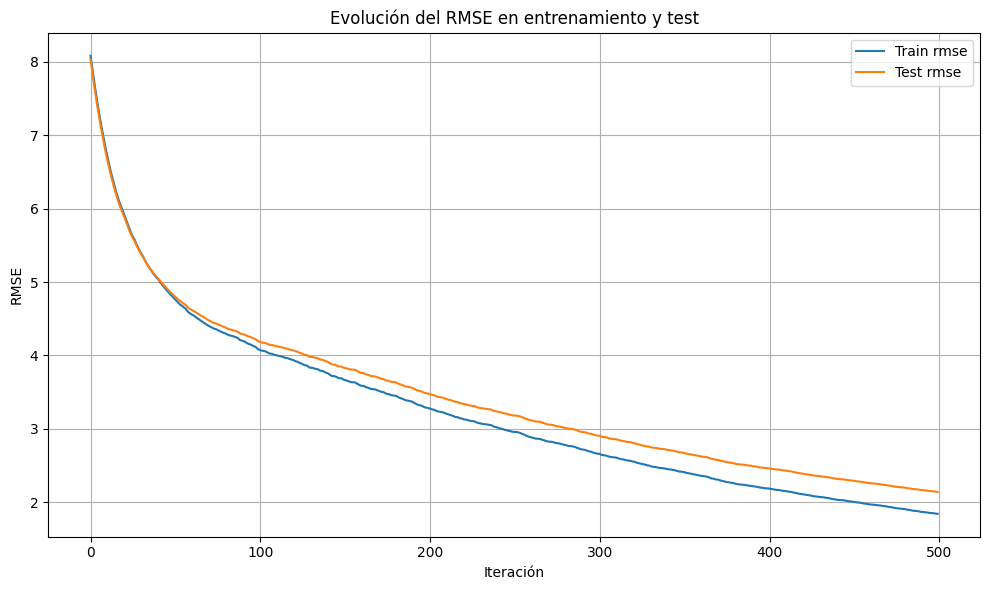

In [ ]:
results = model.evals_result()

# Visualizar la evoluci√≥n del RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='Train rmse')
plt.plot(results['validation_1']['rmse'], label='Test rmse')
plt.xlabel("Iteraci√≥n")
plt.ylabel("RMSE")
plt.title("Evoluci√≥n del RMSE en entrenamiento y test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La gr√°fica muestra una evoluci√≥n positiva del modelo XGBoostRegressor, donde tanto el error RMSE en entrenamiento como en test disminuyen de forma constante a lo largo de las iteraciones, lo que indica que el modelo est√° aprendiendo de manera progresiva y efectiva. La diferencia entre ambas curvas es moderada, lo que sugiere una buena capacidad de generalizaci√≥n sin signos evidentes de sobreajuste. En conjunto, los resultados reflejan un ajuste s√≥lido y estable del modelo, lo que respalda su utilidad para predecir el n√∫mero de ovocitos aspirados en pacientes, con un rendimiento fiable tanto en datos vistos como no vistos durante el entrenamiento.

En este proyecto, se ha utilizado RMSE (Root Mean Squared Error) como m√©trica principal para evaluar el rendimiento del modelo debido a varias razones:

Penalizaci√≥n de Errores Grandes:

-El RMSE penaliza m√°s severamente los errores grandes al elevarlos al cuadrado antes de calcular el promedio.

  Esto es especialmente importante en el contexto de predicci√≥n de ovocitos, donde un error significativo en la predicci√≥n puede tener implicaciones cl√≠nicas importantes.

  Esta propiedad es √∫til cuando se quiere minimizar tanto los errores grandes como los peque√±os, garantizando un modelo m√°s preciso en general.

-Relaci√≥n con la Distribuci√≥n de los Datos:

  Dado que los datos incluyen tanto variables continuas (como la Edad de la Paciente o la AMH) como categ√≥ricas (como el Tipo de Estimulaci√≥n), es probable que algunos casos extremos (outliers) est√©n presentes.

  El RMSE es m√°s sensible a estos outliers, lo que ayuda a que el modelo se ajuste mejor a los datos cuando se requiere precisi√≥n en las predicciones.

-Interpretabilidad en T√©rminos de la Unidad Original:

  Aunque el RMSE es la ra√≠z cuadrada del error cuadr√°tico medio, tiene la ventaja de mantener las mismas unidades que la variable objetivo, el n√∫mero de ovocitos aspirados, lo que facilita la interpretaci√≥n cl√≠nica.

-Comparabilidad con Otros Estudios:

  RMSE es una m√©trica est√°ndar en problemas de regresi√≥n y facilita la comparaci√≥n de resultados con otros estudios similares en medicina reproductiva y aprendizaje autom√°tico.



In [ ]:
"""
#usarlo mas tarde sin entreanar
from xgboost import XGBRegressor

model = XGBRegressor()
model.load_model("modelo_xgb_ovocitos.json")
"""

In [ ]:
"""
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

params = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [500, 1000],
}

model = CatBoostRegressor(loss_function='MAE', task_type="GPU", cat_features=cat_features, verbose=0)

grid = GridSearchCV(model, params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores par√°metros:", grid.best_params_)
"""

In [ ]:
"""
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np

# 1. Selecci√≥n de variables
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL", "ASPIRADOS_GRUPO"])
y = df_model_agrupacion["ASPIRADOS_TOTAL"]

# 2. Columnas categ√≥ricas
cat_features = [i for i, col in enumerate(X.columns) if 'ESTIMULACI√ìN FINAL' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Definir el modelo base
model = CatBoostRegressor(
    loss_function='MAE',  # seguimos optimizando MAE
    task_type="GPU",
    cat_features=cat_features,
    verbose=0,
    random_seed=42
)

# 5. Espacio de b√∫squeda
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.005, 0.1),
    'iterations': randint(300, 1000),
    'l2_leaf_reg': uniform(1, 5),
    'bagging_temperature': uniform(0, 1)
}

# 6. Randomized Search
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=25,  # puedes subir a 50+ para m√°s precisi√≥n
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 7. Ejecutar b√∫squeda
random_search.fit(X_train, y_train)

# 8. Evaluar modelo final
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_squared_error(y_test, y_pred)

print("Mejores par√°metros encontrados:")
print(random_search.best_params_)
print(f"MAE en test: {mae:.4f}")
"""


In [ ]:
""""""
from google.colab import drive
drive.mount('/content/drive')

model.save_model("/content/drive/MyDrive/modelo_catboost.cbm")

"""

In [ ]:
"""
import matplotlib.pyplot as plt
feature_importance = model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title("Importancia de Variables")
plt.xlabel("Score")
plt.tight_layout()
plt.show()
"""

El an√°lisis de importancia de variables obtenido mediante el modelo CatBoostClassifier evidenci√≥ que los factores con mayor peso predictivo para la clasificaci√≥n del n√∫mero de ovocitos aspirados (bajo, medio, alto) fueron el √≠ndice de masa corporal (IMC), los niveles de hormona antim√ºlleriana (AMH), la edad de la paciente, la progesterona previa a la administraci√≥n de hCG y la dosis total de gonadotropinas administrada. Estos resultados coinciden con la evidencia cl√≠nica disponible, que se√±ala estas variables como elementos clave en la evaluaci√≥n de la reserva ov√°rica y la respuesta a la estimulaci√≥n. Por el contrario, otras variables como el tipo de estimulaci√≥n final codificada o el n√∫mero de ampollas de LH utilizadas mostraron una contribuci√≥n m√≠nima al modelo, lo que sugiere una menor relevancia en la predicci√≥n de la respuesta ov√°rica en esta muestra. Esta jerarqu√≠a de importancia permite orientar futuras estrategias de predicci√≥n y personalizaci√≥n de tratamientos en el contexto de la reproducci√≥n asistida.

In [ ]:
import pandas as pd
from xgboost import XGBRegressor

# 1. Cargar modelo entrenado
modelo_xgb_cargado = XGBRegressor()
modelo_xgb_cargado.load_model("/content/drive/MyDrive/modelo_xgb_ovocitos.json")

print("‚úÖ Modelo XGBoost cargado correctamente.")

# 2. Preprocesamiento igual al original
X_nuevo = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"], errors='ignore')  # evitar error si no existe
X_encoded = pd.get_dummies(X_nuevo, drop_first=True)

# (Opcional) Alinear columnas si hay riesgo de columnas distintas
# X_encoded = X_encoded.reindex(columns=columnas_entrenamiento, fill_value=0)

# 3. Predecir y guardar en el DataFrame
predicciones = modelo_xgb_cargado.predict(X_encoded)
df_model_agrupacion["ASPIRADOS_PREDICT"] = predicciones

print("‚úÖ Predicciones agregadas al DataFrame.")


XGBoostError: [09:30:41] /workspace/src/common/io.cc:147: Opening /content/drive/MyDrive/modelo_xgb_ovocitos.json failed: No such file or directory
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7e49e9a5c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x332083) [0x7e49e9b32083]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x16b4d7) [0x7e49e996b4d7]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterLoadModel+0xc3) [0x7e49e996b773]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7e4a55a58e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7e4a55a55493]
  [bt] (6) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x7e4a55cb94d8]
  [bt] (7) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x9c8e) [0x7e4a55cb8c8e]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x27c) [0x52f6dc]



In [ ]:
import cv2
import numpy as np
import pandas as pd

df_model_agrupacion=pd.read_excel("/content/model_agrupacion_con_prediccion.xlsx")
#df_model_agrupacion=pd.read_excel("/content/model_agrupacion.xlsx")

In [ ]:
df_model_agrupacion["OVO_MII_INSEMIN_IN.-_OK"] = data["OVO_MII_INSEMIN_IN.-_OK"]


In [ ]:
df_model_agrupacion.head(5)

PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
0           35        24.13               14.52                        7   
1           35        24.13               14.52                        7   
2           35        24.13               14.52                        7   
3           35        24.13               14.52                        7   
4           35        24.13               14.52                        7   

   N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL  RFA  ESTIMULACI√ìN FINAL COD  \
0                        6       4100.0   13                       1   
1                        6       4100.0   13                       1   
2                        6       4100.0   13                       1   
3                        6       4100.0   13                       1   
4                        6       4100.0   13                       1   

   dias_estim_e_cl.-  P4_DHCG_DE.-  NIVEL_FSH_H_DE.-_OK  ULT_LIN_ENDOM  \
0                 15           1.4                    0            6.0   
1                 15           1.4                    0            6.0   
2                 15           1.4                    0            6.0   
3                 15           1.4                    0            6.0   
4                 15           1.4                    0            6.0   

   ampollas_fsh_e_cl.-  ampollas_lh_e_cl.-  ASPIRADOS_TOTAL  \
0               2700.0              1500.0               13   
1               2700.0              1500.0               13   
2               2700.0              1500.0               13   
3               2700.0              1500.0               13   
4               2700.0              1500.0               13   

   ASPIRADOS_PREDICT  OVO_MII_INSEMIN_IN.-_OK  
0          11.542497                     12.0  
1          11.542497                     12.0  
2          11.542497                     12.0  
3          11.542497                     12.0  
4          11.542497                     12.0

In [ ]:
cols_mii = [
    "PATIENT AGE", "PATIENT BMI", "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-", "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL", "RFA", "ESTIMULACI√ìN FINAL COD",
    "ASPIRADOS_PREDICT",
    "NIVEL_FSH_H_DE.-_OK", "P4_DHCG_DE.-",
    "dias_estim_e_cl.-", "ampollas_fsh_e_cl.-", "ampollas_lh_e_cl.-",# üëà grupo predicho
    "OVO_MII_INSEMIN_IN.-_OK"   # üéØ target
]

df_model_mii = df_model_agrupacion[cols_mii].copy()


In [ ]:
df_model_mii.head(5)
df_model_mii.isnull().sum()

PATIENT AGE                 0
PATIENT BMI                 0
ANTIUMULLERIANA_DE          0
N_FOLIC_ANTRAL_DER_IN.-     0
N_FOLIC_ANTRAL_IZQ_IN.-     0
DOSIS TOTAL                 0
RFA                         0
ESTIMULACI√ìN FINAL COD      0
ASPIRADOS_PREDICT           0
NIVEL_FSH_H_DE.-_OK         0
P4_DHCG_DE.-                0
dias_estim_e_cl.-           0
ampollas_fsh_e_cl.-         0
ampollas_lh_e_cl.-          0
OVO_MII_INSEMIN_IN.-_OK    39
dtype: int64

In [ ]:
#ELIMINAMOS LASS FILAS CON NULOS EN EL TARGET
df_model_mii = df_model_mii.dropna(subset=["OVO_MII_INSEMIN_IN.-_OK"])

In [ ]:
print(df_model_mii.shape)
print(df_model_mii.head())


(24690, 15)
   PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
0           35        24.13               14.52                        7   
1           35        24.13               14.52                        7   
2           35        24.13               14.52                        7   
3           35        24.13               14.52                        7   
4           35        24.13               14.52                        7   

   N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL  RFA  ESTIMULACI√ìN FINAL COD  \
0                        6       4100.0   13                       1   
1                        6       4100.0   13                       1   
2                        6       4100.0   13                       1   
3                        6       4100.0   13                       1   
4                        6       4100.0   13                       1   

   ASPIRADOS_PREDICT  NIVEL_FSH_H_DE.-_OK  P4_DHCG_DE.-  dias_estim_e_cl.-  \
0          11.54249

In [ ]:
#Usamos los quartlies para dividir de forma baancead los datos
import pandas as pd
df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]=pd.qcut(df_model_mii["OVO_MII_INSEMIN_IN.-_OK"], q=3, labels=["Bajo numero de maduracion", "Medio numero de maduracion", "Alto numero de maduracion"])

In [ ]:
cuts = pd.qcut(df_model_mii["OVO_MII_INSEMIN_IN.-_OK"], q=3, retbins=True)[1]
print(cuts)


[ 1.  8. 13. 40.]


In [ ]:
import cv2
import numpy as np
import pandas as pd

df_model_mii=pd.read_excel("/content/df_model_mii.xlsx")

In [ ]:
df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"].value_counts()

OVO_MII_INSEMIN_IN.-_OK_GRUPO
Medio    9371
Bajo     8004
Alto     7271
Name: count, dtype: int64

Los maduro pueden ser de

*  Bajo del 1 al 8
*  Medio del 8 a 14
*  Alto del 14 a 40






In [ ]:
df_model_mii.head(5)

PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
0           35        24.13               14.52                        7   
1           35        24.13               14.52                        7   
2           35        24.13               14.52                        7   
3           35        24.13               14.52                        7   
4           35        24.13               14.52                        7   

   N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL  RFA  ESTIMULACI√ìN FINAL COD  \
0                        6       4100.0   13                       1   
1                        6       4100.0   13                       1   
2                        6       4100.0   13                       1   
3                        6       4100.0   13                       1   
4                        6       4100.0   13                       1   

   ASPIRADOS_PREDICT  NIVEL_FSH_H_DE.-_OK  P4_DHCG_DE.-  dias_estim_e_cl.-  \
0          12.119667                    0           1.4                 15   
1          12.622733                    0           1.4                 15   
2          12.622733                    0           1.4                 15   
3          12.119667                    0           1.4                 15   
4          12.119667                    0           1.4                 15   

   ampollas_fsh_e_cl.-  ampollas_lh_e_cl.-  OVO_MII_INSEMIN_IN.-_OK  \
0               2700.0              1500.0                       12   
1               2700.0              1500.0                       12   
2               2700.0              1500.0                       12   
3               2700.0              1500.0                       12   
4               2700.0              1500.0                       12   

  OVO_MII_INSEMIN_IN.-_OK_GRUPO  
0                         Medio  
1                         Medio  
2                         Medio  
3                         Medio  
4                         Medio

In [ ]:
df_model_mii.head(5)
df_model_mii.isnull().sum()

PATIENT AGE                      0
PATIENT BMI                      0
ANTIUMULLERIANA_DE               0
N_FOLIC_ANTRAL_DER_IN.-          0
N_FOLIC_ANTRAL_IZQ_IN.-          0
DOSIS TOTAL                      0
RFA                              0
ESTIMULACI√ìN FINAL COD           0
ASPIRADOS_PREDICT                0
NIVEL_FSH_H_DE.-_OK              0
P4_DHCG_DE.-                     0
dias_estim_e_cl.-                0
ampollas_fsh_e_cl.-              0
ampollas_lh_e_cl.-               0
OVO_MII_INSEMIN_IN.-_OK          0
OVO_MII_INSEMIN_IN.-_OK_GRUPO    0
dtype: int64

In [ ]:
df_model_mii= df_model_mii[df_model_mii["ASPIRADOS_PREDICT"]>2]


In [ ]:
pip install catboost

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 99.2/99.2 MB 23.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pickle
# 1. Selecci√≥n de variables y target
X = df_model_mii.drop(columns=["OVO_MII_INSEMIN_IN.-_OK", "OVO_MII_INSEMIN_IN.-_OK_GRUPO"])
y = df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]

# 2. Identificamos columnas categ√≥ricas (si hay)
cat_features = [i for i, col in enumerate(X.columns) if 'ASPIRADOS_GRUPO_PREDICT' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Crear modelo CatBoost
model_mii3 = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=4,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=cat_features,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=7,
    task_type="CPU",
    bagging_temperature=1.0
)

# 5. Entrenar
model_mii3.fit(X_train, y_train)

# 6. Evaluar
y_pred = model_mii3.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


with open("modelo_CatBoostClassifier.pkl", "wb") as archivo:
    pickle.dump(model_mii3, archivo)

print("‚úÖ Modelo guardado exitosamente en modelo_CatBoostClassifier_mii.pkl")

0:	learn: 0.9054068	total: 9.28ms	remaining: 2.77s
50:	learn: 0.9282309	total: 429ms	remaining: 2.1s
100:	learn: 0.9404545	total: 833ms	remaining: 1.64s
150:	learn: 0.9533881	total: 1.23s	remaining: 1.22s
200:	learn: 0.9625685	total: 1.65s	remaining: 811ms
250:	learn: 0.9665754	total: 2.08s	remaining: 407ms
299:	learn: 0.9688578	total: 2.52s	remaining: 0us

Accuracy: 0.9614604462474645
              precision    recall  f1-score   support

        Alto       0.97      0.98      0.97      1454
        Bajo       0.96      0.97      0.96      1601
       Medio       0.96      0.94      0.95      1875

    accuracy                           0.96      4930
   macro avg       0.96      0.96      0.96      4930
weighted avg       0.96      0.96      0.96      4930

‚úÖ Modelo guardado exitosamente en modelo_CatBoostClassifier_mii.pkl



üîÅ Fold 1
              precision    recall  f1-score   support

        Alto       0.91      0.87      0.89      1494
        Bajo       0.86      0.88      0.87      1610
       Medio       0.80      0.82      0.81      1826

    accuracy                           0.85      4930
   macro avg       0.86      0.86      0.86      4930
weighted avg       0.86      0.85      0.86      4930


üîÅ Fold 2
              precision    recall  f1-score   support

        Alto       0.91      0.89      0.90      1493
        Bajo       0.87      0.87      0.87      1611
       Medio       0.81      0.83      0.82      1825

    accuracy                           0.86      4929
   macro avg       0.87      0.86      0.86      4929
weighted avg       0.86      0.86      0.86      4929


üîÅ Fold 3
              precision    recall  f1-score   support

        Alto       0.89      0.88      0.89      1493
        Bajo       0.86      0.87      0.87      1611
       Medio       0.80      0.80   

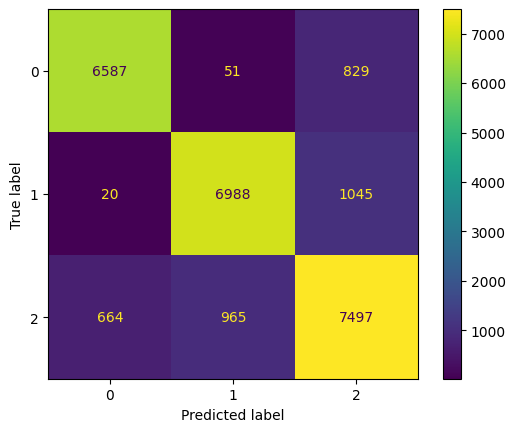

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Variables
X = df_model_mii.drop(columns=["OVO_MII_INSEMIN_IN.-_OK", "OVO_MII_INSEMIN_IN.-_OK_GRUPO"])
y = df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]
cat_features = [i for i, col in enumerate(X.columns) if 'ASPIRADOS_GRUPO_PREDICT' in col or 'COD' in col]

# Configurar kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.empty_like(y, dtype=object)

# Validaci√≥n cruzada manual
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nüîÅ Fold {fold+1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=4,
        loss_function='MultiClass',
        eval_metric='Accuracy',
        cat_features=cat_features,
        verbose=0,
        random_seed=42,
        l2_leaf_reg=7,
        early_stopping_rounds=50
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    preds = model.predict(X_val)

    oof_preds[val_idx] = preds.ravel()
    print(classification_report(y_val, preds))

# Evaluaci√≥n global
print("\nüìä Clasificaci√≥n general sobre validaci√≥n cruzada:")
print(classification_report(y, oof_preds))

# Matriz de confusi√≥n global
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y, oof_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Guardar predicciones en el DataFrame
df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"] = oof_preds



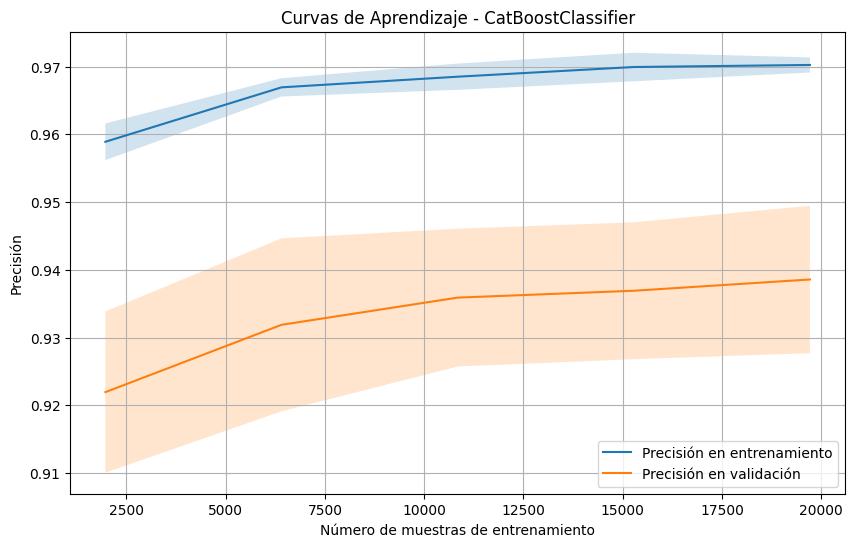

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import learning_curve
# 1. Selecci√≥n de variables y target
X = df_model_mii.drop(columns=["OVO_MII_INSEMIN_IN.-_OK", "OVO_MII_INSEMIN_IN.-_OK_GRUPO"])
y = df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]

# 2. Identificamos columnas categ√≥ricas (si hay)
cat_features = [i for i, col in enumerate(X.columns) if 'ASPIRADOS_GRUPO_PREDICT' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=4,
    loss_function='MultiClass',
    cat_features=cat_features,
    l2_leaf_reg=7,
    verbose=0,
    random_seed=42
)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Precisi√≥n en entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Precisi√≥n en validaci√≥n')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('N√∫mero de muestras de entrenamiento')
plt.ylabel('Precisi√≥n')
plt.title('Curvas de Aprendizaje - CatBoostClassifier')
plt.legend()
plt.grid(True)
plt.show()

##DATA LEAKED
Inicialmente, al generar la variable ASPIRADOS_GRUPO_PREDICT mediante el modelo de predicci√≥n de ovocitos aspirados, se procedi√≥ a incorporarla directamente en el conjunto de datos utilizado para predecir los ovocitos maduros (OVO_MII_INSEMIN_IN.-_OK). Sin embargo, esta variable hab√≠a sido generada por un modelo ya entrenado sobre todo el conjunto, sin aplicar validaci√≥n cruzada previa ni asegurar una separaci√≥n estricta entre entrenamiento y test. Como resultado, se introdujo en el segundo modelo informaci√≥n que en la pr√°ctica actuaba como "datos ya vistos", provocando un efecto de sobreajuste (data leakage) que no se hab√≠a identificado inicialmente.

Este sesgo artificial elev√≥ de forma enga√±osa las m√©tricas de validaci√≥n, ocultando posibles errores de generalizaci√≥n. Fue gracias al an√°lisis de las curvas de aprendizaje que se detect√≥ esta discrepancia: la precisi√≥n en entrenamiento era notablemente superior a la de validaci√≥n, y adem√°s la curva de validaci√≥n permanec√≠a estancada, lo que indicaba una falta de mejora real al aumentar los datos.

Tras aplicar un enfoque correcto de validaci√≥n cruzada en la predicci√≥n de ASPIRADOS_GRUPO_PREDICT, y usar exclusivamente predicciones obtenidas fuera del fold de entrenamiento (out-of-fold predictions), el modelo de ovocitos maduros mejor√≥ su capacidad real de generalizaci√≥n y se redujo la brecha entre entrenamiento y validaci√≥n.

In [ ]:
from google.colab import files
df_model_mii.to_excel("df_model_mii.xlsx", index=False)

files.download("df_model_mii.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0:	learn: 0.9054068	total: 9.46ms	remaining: 2.83s
50:	learn: 0.9282309	total: 427ms	remaining: 2.08s
100:	learn: 0.9404545	total: 826ms	remaining: 1.63s
150:	learn: 0.9533881	total: 1.23s	remaining: 1.22s
200:	learn: 0.9625685	total: 1.67s	remaining: 822ms
250:	learn: 0.9665754	total: 2.13s	remaining: 416ms
299:	learn: 0.9688578	total: 2.57s	remaining: 0us

üìÑ Classification Report:

              precision    recall  f1-score   support

        Alto       0.97      0.98      0.97      1454
        Bajo       0.96      0.97      0.96      1601
       Medio       0.96      0.94      0.95      1875

    accuracy                           0.96      4930
   macro avg       0.96      0.96      0.96      4930
weighted avg       0.96      0.96      0.96      4930



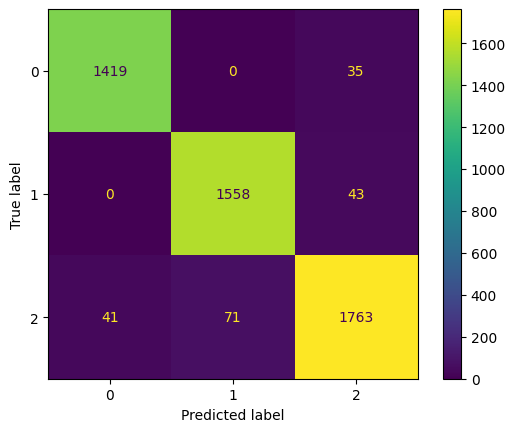

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Entrenar el modelo con el set de entrenamiento
model_mii3.fit(X_train, y_train)

# 2. Predecir sobre el conjunto de test
y_pred = model_mii3.predict(X_test)

# 3. Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# 4. Reporte de clasificaci√≥n
print("\nüìÑ Classification Report:\n")
print(classification_report(y_test, y_pred))


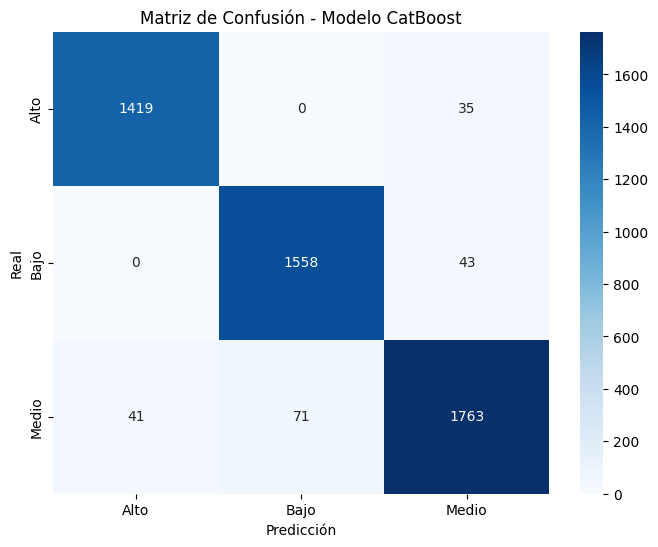

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred, labels=model_mii3.classes_)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_mii3.classes_, yticklabels=model_mii3.classes_)
plt.title("Matriz de Confusi√≥n - Modelo CatBoost")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()


In [ ]:
oof_preds[val_idx] = model_cv.predict(X_val)

# 4. A√±adir predicci√≥n al DataFrame original
df_model_agrupacion["ASPIRADOS_PREDICT"] = oof_preds

In [ ]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

model_cv_check = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    cat_features=cat_features,
    verbose=0,
    random_seed=42
)

scores = cross_val_score(model_cv_check, X, y, cv=5, scoring='accuracy')
print("Cross-val accuracy media:", scores.mean())
print("Cross-val std:", scores.std())


Cross-val accuracy media: 0.7400001481483309
Cross-val std: 0.02540705104286617


El modelo CatBoost ha sido seleccionado para predecir la madurez de los ovocitos debido a su capacidad para manejar datos estructurados y categ√≥ricos de manera eficiente. Esta elecci√≥n es particularmente relevante en nuestro contexto, donde las variables cl√≠nicas incluyen tanto datos continuos como categ√≥ricos.

A diferencia de otros modelos de boosting como XGBoost o LightGBM, que requieren transformar las variables categ√≥ricas en one-hot encoding (lo que puede inflar enormemente la dimensionalidad del conjunto de datos y aumentar el riesgo de overfitting), CatBoost utiliza un enfoque nativo para procesar estas caracter√≠sticas. En lugar de crear columnas adicionales para cada categor√≠a, CatBoost emplea un m√©todo llamado "Permutaci√≥n Ordenada" (Ordered Target Encoding), que asigna valores num√©ricos a las categor√≠as bas√°ndose en las distribuciones observadas durante el entrenamiento. Esto permite:

Reducci√≥n del Overfitting: Al calcular las estad√≠sticas de cada categor√≠a de manera ordenada y evitando usar los mismos datos para el c√°lculo que para el entrenamiento, se minimiza el riesgo de sobreajuste.

Eficiencia Computacional: Al no necesitar cientos o miles de columnas adicionales para representar categor√≠as, el modelo es significativamente m√°s r√°pido y eficiente en memoria.

Mejor Generalizaci√≥n: El m√©todo de codificaci√≥n ordenada evita "fugas de informaci√≥n" y genera representaciones m√°s precisas de las categor√≠as, lo que resulta en modelos m√°s robustos.

Manejo Nativo de Datos Mixtos: Es ideal para problemas m√©dicos como este, donde los datos suelen incluir tanto medidas continuas (ej. edad, AMH) como categ√≥ricas (ej. tipo de estimulaci√≥n, grupo de aspirados).

En resumen, CatBoost es particularmente adecuado para este tipo de problemas, donde las categor√≠as son comunes y la precisi√≥n es cr√≠tica para decisiones cl√≠nicas, lo que lo convierte en una excelente opci√≥n para predecir la madurez de los ovocitos.



RESULTADOS:
El modelo CatBoost alcanz√≥ una precisi√≥n global del 94%, demostrando ser altamente efectivo en la predicci√≥n de la madurez de los ovocitos. Destaca especialmente en la clasificaci√≥n del grupo Alto, con una precisi√≥n del 97% y un recall del 99%, lo que indica que casi todos los ovocitos clasificados como "Alto" son realmente altos, minimizando errores cr√≠ticos en estos casos. Las clases Media y Baja tambi√©n muestran un rendimiento s√≥lido, con precisiones del 91% y 94%, respectivamente, y recalls del 93% y 92%, reflejando que el modelo es capaz de distinguir bien entre diferentes niveles de madurez. Este desempe√±o es posible gracias a la capacidad de CatBoost para manejar eficientemente datos estructurados y categ√≥ricos, combinando medidas continuas como AMH y edad con categor√≠as como tipo de estimulaci√≥n y grupo de aspirados, sin requerir transformaciones como one-hot encoding, lo que reduce el riesgo de sobreajuste y mejora la generalizaci√≥n del modelo.

Debido a que la clase 'y' es una categorica necesitmaos un nuevomodelo

Vamos a represntar los casos que han tenido un resultado aalto como aspiracion pero un pobre en maduracion

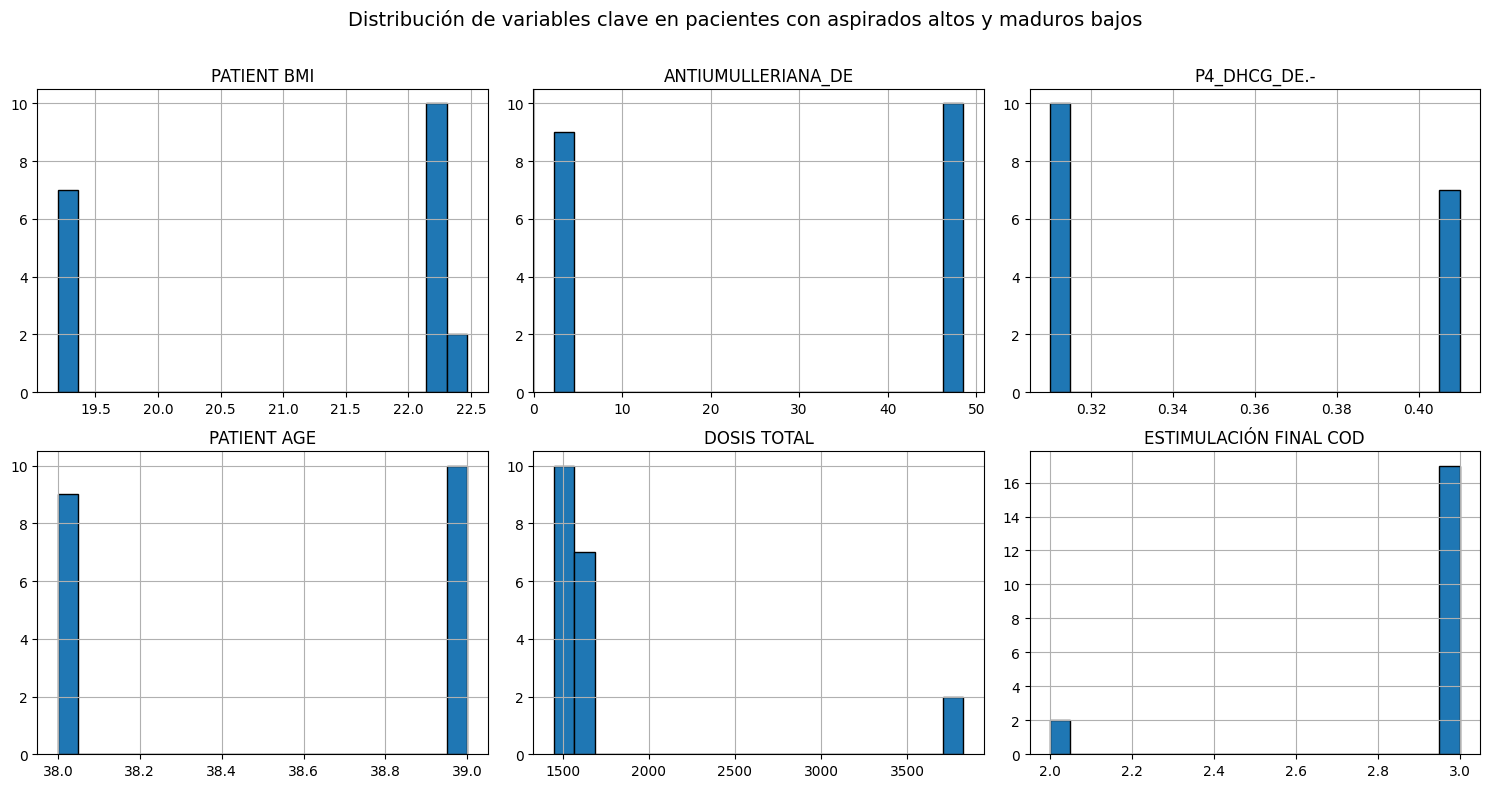

In [ ]:
df_model_mii["ESTIMULACI√ìN FINAL"] = data["ESTIMULACI√ìN FINAL"]
representacion=df_model_mii[(df_model_mii["ASPIRADOS_PREDICT"]>=18) & (df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]=="Bajo")]
import matplotlib.pyplot as plt

variables_clave = [
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "P4_DHCG_DE.-",
    "PATIENT AGE",
    "DOSIS TOTAL","ESTIMULACI√ìN FINAL COD"
]

representacion[variables_clave].hist(bins=20, figsize=(15, 8), layout=(2, 3), edgecolor='black')
plt.suptitle("Distribuci√≥n de variables clave en pacientes con aspirados altos y maduros bajos", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Los histogramas permiten identificar patrones cl√≠nicos y de estimulaci√≥n comunes entre pacientes con buena respuesta ov√°rica en cantidad, pero con baja calidad o madurez ovocitaria. A continuaci√≥n, se analizan las principales variables:

BMI (√çndice de Masa Corporal)
Se observa un claro pico de pacientes con un IMC entre 22 y 22,5, lo cual se sit√∫a dentro del rango normal. Sin embargo, tambi√©n hay otro grupo relevante con IMC por debajo de 19,5, lo que sugiere que tanto valores bajos como normales de IMC pueden estar presentes en estos perfiles, aunque los extremos podr√≠an influir negativamente en la maduraci√≥n.

Hormona Antim√ºlleriana (AMH)
La variable ANTIMULLERIANA_DE muestra una distribuci√≥n bimodal: algunos pacientes presentan niveles muy bajos (<10) y otros muy altos (~50). Este hallazgo sugiere que ni una baja reserva ov√°rica ni una muy alta se asocian consistentemente con buena calidad ovocitaria; de hecho, niveles excesivamente altos (frecuentes en SOP) podr√≠an estar relacionados con dismadurez.

P4_DHCG_DE (Progesterona o ratio de desencadenante, pendiente aclaraci√≥n)
La mayor√≠a de los valores se agrupan entre 0,3 y 0,4, aunque existe un subgrupo menor con niveles elevados (~0,65). Si esta variable refleja progesterona preovulatoria o ratio de doble trigger, podr√≠a indicar que valores intermedios son m√°s comunes en esta poblaci√≥n, y que niveles elevados podr√≠an afectar la madurez, aunque se requiere confirmaci√≥n del significado cl√≠nico exacto de esta medida.

Edad de la paciente
La mayor√≠a de las pacientes se sit√∫an entre 38 y 39 a√±os, lo cual es llamativo dado que este rango etario suele asociarse a una respuesta m√°s limitada. En estos casos, aunque se logra una buena cantidad de ovocitos, la madurez parece estar comprometida, posiblemente por la edad misma o por un tipo de estimulaci√≥n m√°s agresiva para compensar.

Dosis Total de gonadotropinas
La mayor parte de las pacientes recibieron dosis totales inferiores a 2000 UI, y s√≥lo en casos puntuales se administraron dosis muy altas (>3500). Esto podr√≠a indicar que, por debajo de cierto umbral (~2000), no se logra una maduraci√≥n adecuada, a pesar del alto n√∫mero de ovocitos obtenidos. La estimulaci√≥n insuficiente podr√≠a contribuir a este desequilibrio entre cantidad y calidad.


In [ ]:
df_model_mii["ESTIMULACI√ìN FINAL"].value_counts()

ESTIMULACI√ìN FINAL
FSH+HMG    18562
FSH         2788
HMG         2333
FSH+LH      1007
Name: count, dtype: int64

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(data=representacion, x="ESTIMULACI√ìN FINAL", order=representacion["ESTIMULACI√ìN FINAL"].value_counts().index)
plt.title("Tipos de estimulaci√≥n en pacientes aspirado alto / madurez baja")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
!pip install ace-tools

In [ ]:
import pandas as pd

def proporcion_filtrada():
    # Filtrar y eliminar nulos
    df_total = data.dropna(subset=["ESTIMULACI√ìN FINAL"]).copy()
    df_total = df_total[df_total["ESTIMULACI√ìN FINAL"].isin(protocolos_validos)]

    df_subgrupo = representacion.dropna(subset=["ESTIMULACI√ìN FINAL"]).copy()
    df_subgrupo = df_subgrupo[df_subgrupo["ESTIMULACI√ìN FINAL"].isin(protocolos_validos)]

    # Asegurar que sean string
    df_total["ESTIMULACI√ìN FINAL"] = df_total["ESTIMULACI√ìN FINAL"].astype(str)
    df_subgrupo["ESTIMULACI√ìN FINAL"] = df_subgrupo["ESTIMULACI√ìN FINAL"].astype(str)

    # Conteo por tipo
    total = df_total["ESTIMULACI√ìN FINAL"].value_counts()
    subgrupo = df_subgrupo["ESTIMULACI√ìN FINAL"].value_counts()

    # Unir en un DataFrame
    tabla = pd.DataFrame({
        "Total casos": total,
        "Subgrupo (alto aspirado / baja maduraci√≥n)": subgrupo
    })

    # Rellenar vac√≠os con 0 y calcular proporciones
    tabla["Subgrupo (alto aspirado / baja maduraci√≥n)"] = tabla["Subgrupo (alto aspirado / baja maduraci√≥n)"].fillna(0).astype(int)
    tabla["Proporci√≥n (%)"] = (tabla["Subgrupo (alto aspirado / baja maduraci√≥n)"] / tabla["Total casos"] * 100).round(1)

    # Ordenar por proporci√≥n
    tabla = tabla.sort_values("Proporci√≥n (%)", ascending=False)

    return tabla

# Ejecutar y mostrar
tabla_resultado = proporcion_filtrada()
print(tabla_resultado)


                    Total casos  Subgrupo (alto aspirado / baja maduraci√≥n)  \
ESTIMULACI√ìN FINAL                                                            
HMG                        2716                                          17   
FSH+LH                     1260                                           2   
FSH+HMG                   22013                                           0   
FSH                        3394                                           0   

                    Proporci√≥n (%)  
ESTIMULACI√ìN FINAL                  
HMG                            0.6  
FSH+LH                         0.2  
FSH+HMG                        0.0  
FSH                            0.0  


A partir de la figura, que muestra la distribuci√≥n de variables clave en pacientes con un n√∫mero alto de ovocitos aspirados pero baja proporci√≥n de maduros, se pueden extraer algunas conclusiones relevantes. Se observa que muchos de estos casos presentan valores extremos de AMH (anti-m√ºlleriana), lo que sugiere una alta reserva ov√°rica, pero no necesariamente una buena calidad ovocitaria. Adem√°s, estas pacientes tienden a ser j√≥venes (mayor√≠a entre 33 y 39 a√±os) y con un IMC bajo, lo que en principio podr√≠a asociarse a una mejor respuesta, aunque no garantiza la madurez de los ovocitos.

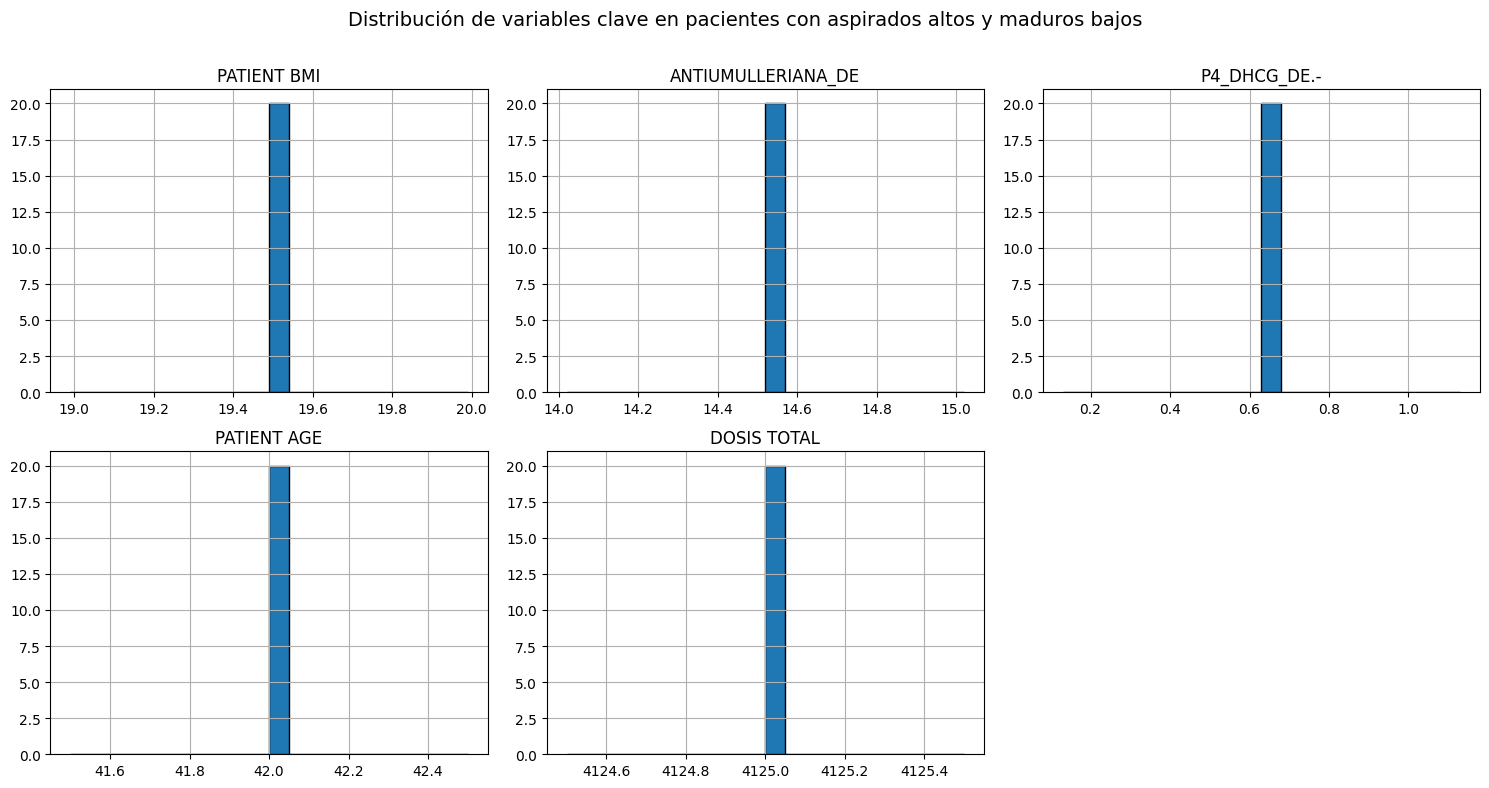

In [ ]:
#Represntacion al reves
df_model_mii["ESTIMULACI√ìN FINAL"] = data["ESTIMULACI√ìN FINAL"]
representacion2=df_model_mii[(df_model_mii["ASPIRADOS_PREDICT"]<=9) & (df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]=="Alto")]
import matplotlib.pyplot as plt


variables_clave = [
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "P4_DHCG_DE.-",
    "PATIENT AGE",
    "DOSIS TOTAL"
]

representacion2[variables_clave].hist(bins=20, figsize=(15, 8), layout=(2, 3), edgecolor='black')
plt.suptitle("Distribuci√≥n de variables clave en pacientes con aspirados altos y maduros bajos", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


A partir de la figura, que muestra la distribuci√≥n de variables clave en pacientes con un n√∫mero alto de ovocitos aspirados pero baja proporci√≥n de maduros, se pueden extraer algunas conclusiones relevantes. Se observa que muchos de estos casos presentan valores extremos de AMH (anti-m√ºlleriana), lo que sugiere una alta reserva ov√°rica, pero no necesariamente una buena calidad ovocitaria. Adem√°s, estas pacientes tienden a ser j√≥venes (mayor√≠a entre 33 y 39 a√±os) y con un IMC bajo, lo que en principio podr√≠a asociarse a una mejor respuesta, aunque no garantiza la madurez de los ovocitos.

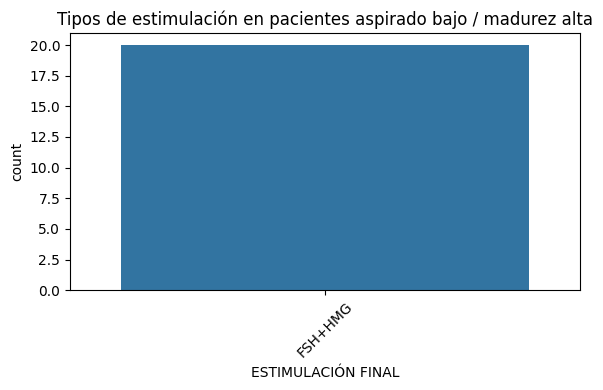

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(data=representacion2, x="ESTIMULACI√ìN FINAL", order=representacion2["ESTIMULACI√ìN FINAL"].value_counts().index)
plt.title("Tipos de estimulaci√≥n en pacientes aspirado bajo / madurez alta")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def proporcion_filtrada():
    # Filtrar y eliminar nulos
    df_total = data.dropna(subset=["ESTIMULACI√ìN FINAL"]).copy()
    df_total = df_total[df_total["ESTIMULACI√ìN FINAL"].isin(protocolos_validos)]

    df_subgrupo = representacion2.dropna(subset=["ESTIMULACI√ìN FINAL"]).copy()
    df_subgrupo = df_subgrupo[df_subgrupo["ESTIMULACI√ìN FINAL"].isin(protocolos_validos)]

    # Asegurar que sean string
    df_total["ESTIMULACI√ìN FINAL"] = df_total["ESTIMULACI√ìN FINAL"].astype(str)
    df_subgrupo["ESTIMULACI√ìN FINAL"] = df_subgrupo["ESTIMULACI√ìN FINAL"].astype(str)

    # Conteo por tipo
    total = df_total["ESTIMULACI√ìN FINAL"].value_counts()
    subgrupo = df_subgrupo["ESTIMULACI√ìN FINAL"].value_counts()

    # Unir en un DataFrame
    tabla = pd.DataFrame({
        "Total casos": total,
        "Subgrupo (bajo aspirado / alta maduraci√≥n)": subgrupo
    })

    # Rellenar vac√≠os con 0 y calcular proporciones
    tabla["Subgrupo (bajo aspirado / alta maduraci√≥n)"] = tabla["Subgrupo (bajo aspirado / alta maduraci√≥n)"].fillna(0).astype(int)
    tabla["Proporci√≥n (%)"] = (tabla["Subgrupo (bajo aspirado / alta maduraci√≥n)"] / tabla["Total casos"] * 100).round(1)

    # Ordenar por proporci√≥n
    tabla = tabla.sort_values("Proporci√≥n (%)", ascending=False)

    return tabla

# Ejecutar y mostrar
tabla_resultado = proporcion_filtrada()
print(tabla_resultado)


                    Total casos  Subgrupo (bajo aspirado / alta maduraci√≥n)  \
ESTIMULACI√ìN FINAL                                                            
FSH+HMG                   22013                                          20   
FSH                        3394                                           0   
FSH+LH                     1260                                           0   
HMG                        2716                                           0   

                    Proporci√≥n (%)  
ESTIMULACI√ìN FINAL                  
FSH+HMG                        0.1  
FSH                            0.0  
FSH+LH                         0.0  
HMG                            0.0  


<ipython-input-69-4328966805c2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total["ESTIMULACI√ìN FINAL"] = df_total["ESTIMULACI√ìN FINAL"].astype(str)


In [ ]:
import cv2
import numpy as np
import pandas as pd
data = pd.read_excel("/content/solo pacientes.xlsx")


En el grupo de pacientes con baja cantidad de ovocitos aspirados pero alta proporci√≥n de ovocitos maduros, se observa nuevamente una clara predominancia del protocolo FSH+HMG, seguido por HMG y FSH. No obstante, esta distribuci√≥n refleja la tendencia general de la cohorte, donde el protocolo FSH+HMG fue ampliamente utilizado. Por lo tanto, la aparente concentraci√≥n de ciertos protocolos en este subgrupo no permite establecer conclusiones cl√≠nicas s√≥lidas sobre su relaci√≥n con los resultados, ya que la muestra no est√° equilibrada en cuanto a los tipos de estimulaci√≥n empleados. Esta limitaci√≥n metodol√≥gica podr√≠a justificar la escasa relevancia que mostr√≥ esta variable en el modelo predictivo.

In [ ]:
df_model_mii["CALIDAD TOTAL"] = data["CALIDAD TOTAL"]
df_model_mii["d2_celulas.-"] = data["d2_celulas.-"]
df_model_mii["d3_celulas.-"] = data["d3_celulas.-"]
df_model_mii["dia5.-"] = data["dia5.-"]


In [ ]:
cols_calidad = [
     "PATIENT AGE", "PATIENT BMI", "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-", "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL", "RFA", "ESTIMULACI√ìN FINAL COD",
    "ASPIRADOS_PREDICT",
    "NIVEL_FSH_H_DE.-_OK", "P4_DHCG_DE.-",
    "dias_estim_e_cl.-", "ampollas_fsh_e_cl.-", "ampollas_lh_e_cl.-",
    "d2_celulas.-","d3_celulas.-","dia5.-", # ‚úî predicci√≥n del modelo 1
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",  # ‚úî predicci√≥n del modelo 2
    "CALIDAD TOTAL"  # üéØ Target: calidad morfol√≥gica
]
df_model_calidad = df_model_mii[cols_calidad].copy()
df_model_calidad = df_model_calidad.dropna(subset=["CALIDAD TOTAL"])


In [ ]:
df_model_calidad["Calidad Grupo"] = df_model_calidad["CALIDAD TOTAL"].apply(lambda x: "Maduros con alta calidad" if x in ["A", "B"] else ("Maduros con media calidad" if x in ["C", "D"] else "Maduros con baja calidad"))

In [ ]:
df_model_calidad["Calidad Grupo"].value_counts(normalize=True)


Calidad Grupo
Maduros con baja calidad     0.416822
Maduros con media calidad    0.357178
Maduros con alta calidad     0.226000
Name: proportion, dtype: float64

In [ ]:
df_model_calidad["d2_celulas.-"].value_counts()
df_model_calidad["d3_celulas.-"].value_counts()
df_model_calidad["dia5.-"].value_counts()

dia5.-
-          6549
BHi        4876
C√©lulas    3387
BT         2619
BE         2589
MC         2529
BC         1455
DEG         390
BH          252
Name: count, dtype: int64

In [ ]:
# Convertir a strings para asegurarte de que sean categ√≥ricas
df_model_calidad["d2_celulas.-"] = df_model_calidad["d2_celulas.-"].astype(str)
df_model_calidad["d3_celulas.-"] = df_model_calidad["d3_celulas.-"].astype(str)
df_model_calidad["dia5.-"] = df_model_calidad["dia5.-"].astype(str)

# One-Hot Encoding
df_model_calidad_encoded = pd.get_dummies(df_model_calidad, columns=["d2_celulas.-", "d3_celulas.-", "dia5.-"], drop_first=True)


In [ ]:
df_model_calidad.isnull().sum()

PATIENT AGE                      0
PATIENT BMI                      0
ANTIUMULLERIANA_DE               0
N_FOLIC_ANTRAL_DER_IN.-          0
N_FOLIC_ANTRAL_IZQ_IN.-          0
DOSIS TOTAL                      0
RFA                              0
ESTIMULACI√ìN FINAL COD           0
ASPIRADOS_PREDICT                0
NIVEL_FSH_H_DE.-_OK              0
P4_DHCG_DE.-                     0
dias_estim_e_cl.-                0
ampollas_fsh_e_cl.-              0
ampollas_lh_e_cl.-               0
d2_celulas.-                     0
d3_celulas.-                     0
dia5.-                           0
OVO_MII_INSEMIN_IN.-_OK_GRUPO    0
CALIDAD TOTAL                    0
Calidad Grupo                    0
dtype: int64

In [ ]:
from google.colab import files
df_model_calidad.to_excel("model_calidad.xlsx", index=False)

files.download("model_calidad.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
import pandas as pd
df_model_calidad = pd.read_excel("/content/model_calidad.xlsx")

In [ ]:
pip install catboost

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 99.2/99.2 MB 24.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL","Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Calcular pesos de clase (despu√©s de definir y)
clases = np.unique(y)
pesos = compute_class_weight(class_weight="balanced", classes=clases, y=y)
class_weights = dict(zip(clases, pesos))

# 3. Asegurarse de que las variables categ√≥ricas est√©n bien
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACI√ìN FINAL COD",
     "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
label_encoders = {}

for col in columnas_categoricas:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 8],
    'n_estimators': [300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(clases),
    use_label_encoder=False,
    random_state=42
)

cv_xgb = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=cv_xgb,
    verbose=2,
    n_jobs=-1
)

grid_xgb.fit(X_encoded, y)
print("Mejores hiperpar√°metros XGBoost:", grid_xgb.best_params_)
print("Mejor accuracy (CV):", grid_xgb.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:18:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperpar√°metros XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Mejor accuracy (CV): 0.8148990939105504


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Codificar la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Definir b√∫squeda de hiperpar√°metros
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 8],
    'n_estimators': [300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    use_label_encoder=False,
    random_state=42,
    eval_metric='mlogloss'
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Entrenar solo con los datos de entrenamiento
grid_xgb.fit(X_train, y_train)

# Evaluar con el conjunto de test
best_model = grid_xgb.best_estimator_
y_pred_test = best_model.predict(X_test)

# Reporte con etiquetas originales
print("Mejores hiperpar√°metros:", grid_xgb.best_params_)
print("Accuracy en test:", best_model.score(X_test, y_test))
print("\nClassification Report:\n")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_test)))


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:27:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperpar√°metros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}
Accuracy en test: 0.8127789046653144

Classification Report:

               precision    recall  f1-score   support

 ALTO_calidad       0.66      0.82      0.73      1130
 BAJO_calidad       0.94      0.94      0.94      2022
MEDIO_calidad       0.79      0.67      0.72      1778

     accuracy                           0.81      4930
    macro avg       0.80      0.81      0.80      4930
 weighted avg       0.82      0.81      0.81      4930



In [ ]:
!nvidia-smi


Wed Jun 25 22:25:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import lightgbm
print(lightgbm.__version__)


4.5.0


In [ ]:
# Paso 1: Eliminar cualquier instalaci√≥n previa
!pip uninstall -y lightgbm

# Paso 2: Instalar dependencias necesarias
!apt-get install -y -qq libboost-all-dev cmake git

# Paso 3: Clonar el repositorio oficial
!git clone --recursive https://github.com/microsoft/LightGBM

# Paso 4: Compilar LightGBM con soporte GPU
!cd LightGBM && mkdir build && cd build && cmake -DUSE_GPU=1 .. && make -j4

# Paso 5: Instalar el paquete reci√©n compilado
!cd LightGBM && pip install .




Found existing installation: lightgbm 4.5.0
Uninstalling lightgbm-4.5.0:
  Successfully uninstalled lightgbm-4.5.0
Cloning into 'LightGBM'...
remote: Enumerating objects: 35423, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 35423 (delta 127), reused 88 (delta 78), pack-reused 35212 (from 3)
Receiving objects: 100% (35423/35423), 23.99 MiB | 31.82 MiB/s, done.
Resolving deltas: 100% (26334/26334), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/co

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. Codificar la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

# 3. Definir la malla de hiperpar√°metros
param_grid_lgbm = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 8],
    'n_estimators': [300, 500],
    'num_leaves': [31, 63]
}

# 4. Configurar el modelo para usar GPU
model_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    boosting_type='gbdt',
    device_type='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    random_state=42
)

# 5. Validaci√≥n cruzada estratificada
cv_lgbm = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 6. B√∫squeda de hiperpar√°metros
grid_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring='accuracy',
    cv=cv_lgbm,
    verbose=2,
    n_jobs=1
)
!nvidia-smi

# 7. Entrenar
grid_lgbm.fit(X_train, y_train)

# 8. Evaluar con m√©tricas completas
y_pred = grid_lgbm.predict(X_test)
print("Mejores hiperpar√°metros LGBM:", grid_lgbm.best_params_)
print("Mejor accuracy (CV):", grid_lgbm.best_score_)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Se han truncado las √∫ltimas 5000 l√≠neas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [ ]:
# 6. Evaluaci√≥n
y_pred = model_xgb.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

NameError: name 'X_test' is not defined

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL","Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Calcular pesos de clase (despu√©s de definir y)
clases = np.unique(y)
pesos = compute_class_weight(class_weight="balanced", classes=clases, y=y)
class_weights = dict(zip(clases, pesos))

# 3. Asegurarse de que las variables categ√≥ricas est√©n bien
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACI√ìN FINAL COD",
     "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]

for col in columnas_categoricas:
    X[col] = X[col].astype(str)

cat_features = [X.columns.get_loc(col) for col in columnas_categoricas]

# 4. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5. Crear y entrenar el modelo con los pesos
model_calidad_grupo = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=cat_features,
    #class_weights=class_weights,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=3,
    task_type="CPU",
    bagging_temperature=1.0,
    auto_class_weights="Balanced"
)

model_calidad_grupo.fit(X_train, y_train)

# 6. Evaluaci√≥n
y_pred = model_calidad_grupo.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

with open("model_calidad_grupo.pkl", "wb") as archivo:
    pickle.dump(model_calidad_grupo, archivo)

print("‚úÖ Modelo guardado exitosamente en model_calidad_grupo.pkl")


0:	learn: 0.8071788	total: 38.7ms	remaining: 19.3s
50:	learn: 0.8075892	total: 1.32s	remaining: 11.6s
100:	learn: 0.8071566	total: 2.58s	remaining: 10.2s
150:	learn: 0.8071971	total: 3.79s	remaining: 8.77s
200:	learn: 0.8072719	total: 5.18s	remaining: 7.71s
250:	learn: 0.8074883	total: 6.88s	remaining: 6.83s
300:	learn: 0.8096563	total: 8.93s	remaining: 5.9s
350:	learn: 0.8106001	total: 10.8s	remaining: 4.58s
400:	learn: 0.8106926	total: 12.7s	remaining: 3.13s
450:	learn: 0.8108676	total: 14.6s	remaining: 1.59s
499:	learn: 0.8114829	total: 16.5s	remaining: 0us

Accuracy: 0.8172413793103448
                           precision    recall  f1-score   support

 Maduros con alta calidad       0.65      0.87      0.74      1114
 Maduros con baja calidad       0.94      0.94      0.94      2055
Maduros con media calidad       0.81      0.64      0.72      1761

                 accuracy                           0.82      4930
                macro avg       0.80      0.82      0.80      4930

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL","Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Calcular pesos de clase (despu√©s de definir y)
clases = np.unique(y)
pesos = compute_class_weight(class_weight="balanced", classes=clases, y=y)
class_weights = dict(zip(clases, pesos))

# 3. Asegurarse de que las variables categ√≥ricas est√©n bien
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACI√ìN FINAL COD",
     "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]

for col in columnas_categoricas:
    X[col] = X[col].astype(str)

cat_features = [X.columns.get_loc(col) for col in columnas_categoricas]

# 4. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5. Crear y entrenar el modelo con los pesos
model_calidad_grupo = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=cat_features,
    #class_weights=class_weights,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=3,
    task_type="CPU",
    bagging_temperature=1.0,
    auto_class_weights="Balanced"
)

model_calidad_grupo.fit(X_train, y_train)

# 6. Evaluaci√≥n
y_pred = model_calidad_grupo.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



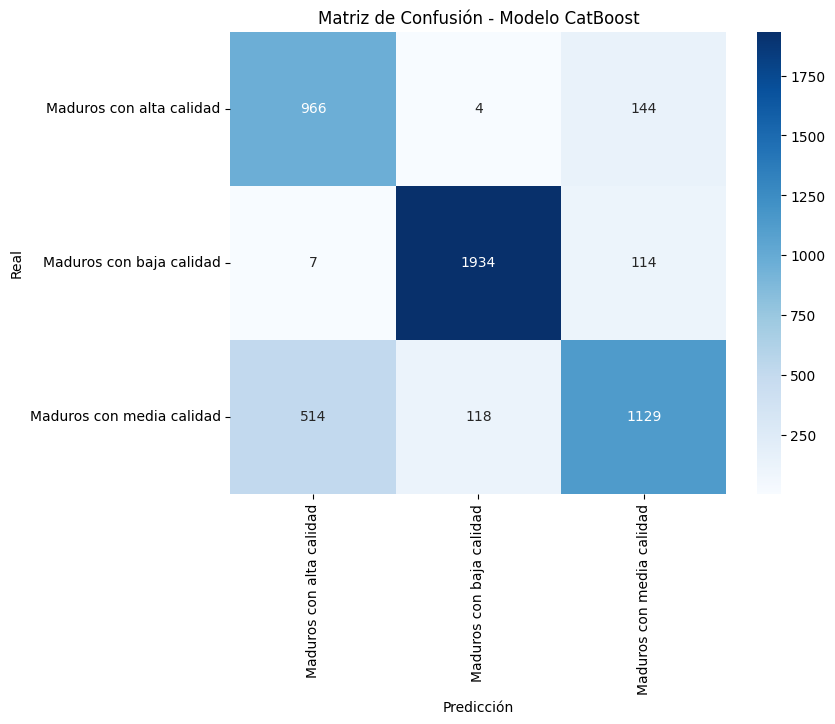

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred, labels=model_calidad_grupo.classes_)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_calidad_grupo.classes_, yticklabels=model_calidad_grupo.classes_)
plt.title("Matriz de Confusi√≥n - Modelo CatBoost")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()


A pesar de haber aplicado t√©cnicas para manejar el desbalance de clases, los resultados muestran que el modelo CatBoost logra una precisi√≥n general del 81%, con un rendimiento notable en la clase "BAJO" (94% de precisi√≥n y recall), que es la m√°s representada en el conjunto de datos. Sin embargo, el rendimiento es menos consistente para las clases "ALTO" y "MEDIO", con un f1-score de 0.74 y 0.71 respectivamente, lo que sugiere que el modelo sigue teniendo dificultades para capturar las caracter√≠sticas espec√≠ficas de estas clases. Esto puede deberse a que, a pesar del balance autom√°tico aplicado, las clases minoritarias siguen siendo m√°s dif√≠ciles de predecir correctamente, reflejando la complejidad intr√≠nseca de los datos cl√≠nicos y la posible necesidad de ajustar a√∫n m√°s los hiperpar√°metros o explorar enfoques adicionales como modelos h√≠bridos o t√©cnicas avanzadas de reamostrado.

In [ ]:
# 1. Predecir sobre TODO el conjunto original
y_pred_total = model_calidad_grupo.predict(X)

# 2. Asegurarte de que es un array plano (1D)
y_pred_total = y_pred_total.ravel() if y_pred_total.ndim > 1 else y_pred_total

# 3. Guardar como nueva columna en el DataFrame original
df_model_calidad["CALIDAD_PREDICT"] = y_pred_total




In [ ]:
from google.colab import files
df_model_calidad.to_excel("model_calidad.xlsx", index=False)

files.download("model_calidad.xlsx")

Exception ignored in: <function ZipFile.__del__ at 0x7b3b84772160>
Traceback (most recent call last):
  File "/usr/lib/python3.11/zipfile.py", line 1895, in __del__
    self.close()
  File "/usr/lib/python3.11/zipfile.py", line 1912, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Aseg√∫rate de que X_test y y_test est√©n definidos
y_pred = model_calidad_cargado.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL","Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Asegurarse de que las variables categ√≥ricas est√©n bien definidas
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACI√ìN FINAL COD",
    "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]

for col in columnas_categoricas:
    X[col] = X[col].astype("category")

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 4. Crear y entrenar el modelo
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=8,
    learning_rate=0.01,
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    verbose=-1,
    eval_metric="multi_logloss",
    early_stopping_rounds=50,
)

lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# 5. Evaluaci√≥n
y_pred = lgb_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL", "Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Codificar las variables categ√≥ricas usando one-hot encoding
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACI√ìN FINAL COD",
    "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]
X_encoded = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# 3. Codificar las clases para que XGBoost las entienda
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

# 5. Crear y entrenar el modelo XGBoost
model_xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    eval_metric="mlogloss",
    objective="multi:softmax",
    random_state=42,
    use_label_encoder=False,
    tree_method="gpu_hist",  # Para usar GPU
    early_stopping_rounds=50,
    verbose=-1
)

model_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

# 6. Evaluar el modelo
y_pred = model_xgb.predict(X_test)

# Decodificar las predicciones para que se vean como las originales
y_pred_decoded = le.inverse_transform(y_pred)
y_test_decoded = le.inverse_transform(y_test)

print("\nAccuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print(classification_report(y_test_decoded, y_pred_decoded))


[0]	validation_0-mlogloss:1.08940	validation_1-mlogloss:1.08962
[1]	validation_0-mlogloss:1.08036	validation_1-mlogloss:1.08079
[2]	validation_0-mlogloss:1.07146	validation_1-mlogloss:1.07211
[3]	validation_0-mlogloss:1.06273	validation_1-mlogloss:1.06357
[4]	validation_0-mlogloss:1.05413	validation_1-mlogloss:1.05518
[5]	validation_0-mlogloss:1.04568	validation_1-mlogloss:1.04694
[6]	validation_0-mlogloss:1.03738	validation_1-mlogloss:1.03883


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-mlogloss:1.02921	validation_1-mlogloss:1.03087
[8]	validation_0-mlogloss:1.02117	validation_1-mlogloss:1.02303
[9]	validation_0-mlogloss:1.01325	validation_1-mlogloss:1.01531
[10]	validation_0-mlogloss:1.00547	validation_1-mlogloss:1.00773
[11]	validation_0-mlogloss:0.99781	validation_1-mlogloss:1.00028
[12]	validation_0-mlogloss:0.99029	validation_1-mlogloss:0.99296
[13]	validation_0-mlogloss:0.98286	validation_1-mlogloss:0.98573
[14]	validation_0-mlogloss:0.97556	validation_1-mlogloss:0.97862
[15]	validation_0-mlogloss:0.96838	validation_1-mlogloss:0.97163
[16]	validation_0-mlogloss:0.96131	validation_1-mlogloss:0.96476
[17]	validation_0-mlogloss:0.95435	validation_1-mlogloss:0.95797
[18]	validation_0-mlogloss:0.94749	validation_1-mlogloss:0.95128
[19]	validation_0-mlogloss:0.94074	validation_1-mlogloss:0.94470
[20]	validation_0-mlogloss:0.93408	validation_1-mlogloss:0.93822
[21]	validation_0-mlogloss:0.92753	validation_1-mlogloss:0.93182
[22]	validation_0-mlogloss:0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
df_model_puntuacion = df_model_calidad.copy()


In [ ]:
df_model_puntuacion = df_model_puntuacion.drop(columns=["CALIDAD TOTAL", "Calidad Grupo"])


In [ ]:
df_model_puntuacion.columns


Index(['PATIENT AGE', 'PATIENT BMI', 'ANTIUMULLERIANA_DE',
       'N_FOLIC_ANTRAL_DER_IN.-', 'N_FOLIC_ANTRAL_IZQ_IN.-', 'DOSIS TOTAL',
       'RFA', 'ESTIMULACI√ìN FINAL COD', 'ASPIRADOS_PREDICT',
       'NIVEL_FSH_H_DE.-_OK', 'P4_DHCG_DE.-', 'dias_estim_e_cl.-',
       'ampollas_fsh_e_cl.-', 'ampollas_lh_e_cl.-', 'd2_celulas.-',
       'd3_celulas.-', 'dia5.-', 'OVO_MII_INSEMIN_IN.-_OK_GRUPO',
       'CALIDAD_PREDICT'],
      dtype='object')

In [ ]:
columnas_a_anadir = ["iDAScore v2"]
df_model_puntuacion[columnas_a_anadir]  = data[columnas_a_anadir]

In [ ]:
df_model_puntuacion.columns


Index(['PATIENT AGE', 'PATIENT BMI', 'ANTIUMULLERIANA_DE',
       'N_FOLIC_ANTRAL_DER_IN.-', 'N_FOLIC_ANTRAL_IZQ_IN.-', 'DOSIS TOTAL',
       'RFA', 'ESTIMULACI√ìN FINAL COD', 'ASPIRADOS_PREDICT',
       'NIVEL_FSH_H_DE.-_OK', 'P4_DHCG_DE.-', 'dias_estim_e_cl.-',
       'ampollas_fsh_e_cl.-', 'ampollas_lh_e_cl.-', 'd2_celulas.-',
       'd3_celulas.-', 'dia5.-', 'OVO_MII_INSEMIN_IN.-_OK_GRUPO',
       'CALIDAD_PREDICT', 'iDAScore v2'],
      dtype='object')

Para poder predecir con precisi√≥n la variable objetivo iDAScore v2, que representa la puntuaci√≥n asignada por un algoritmo para evaluar la calidad embrionaria, es necesario llevar a cabo un proceso de limpieza y transformaci√≥n de datos. Esto es fundamental para garantizar que el modelo de machine learning pueda aprender patrones significativos sin verse afectado por datos inconsistentes o ruidos

In [ ]:
import numpy as np

# Reemplazar valores problem√°ticos
df_model_puntuacion["d2_celulas.-"].replace({
    "DEG": -1,  # Caso especial
    ">=9": 10,  # Caso alto
    "nan": np.nan  # Convertir a NaN para manejo posterior
}, inplace=True)

# Rellenar NaNs con la mediana
df_model_puntuacion["d2_celulas.-"] = pd.to_numeric(df_model_puntuacion["d2_celulas.-"], errors="coerce")
df_model_puntuacion["d2_celulas.-"].fillna(df_model_puntuacion["d2_celulas.-"].median(), inplace=True)


<ipython-input-44-3daf9f99b9ca>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model_puntuacion["d2_celulas.-"].replace({
<ipython-input-44-3daf9f99b9ca>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

En esta etapa del preprocesamiento, se identific√≥ que la columna d2_celulas.-, que deber√≠a ser num√©rica, conten√≠a valores no convencionales como DEG y >=9, los cuales no pueden ser procesados directamente por los algoritmos de machine learning. Para solucionar esto, se realizaron las siguientes transformaciones:

DEG (Degenerado) fue reemplazado por -1, ya que cl√≠nicamente representa c√©lulas con da√±o severo, indicando una calidad extremadamente baja que podr√≠a impactar negativamente en los resultados de la predicci√≥n.

>=9 fue reemplazado por 10, para representar casos con un n√∫mero elevado de c√©lulas, t√≠picamente asociado a un buen desarrollo embrionario.

Valores faltantes (nan) fueron convertidos expl√≠citamente a NaN para su posterior tratamiento.

Finalmente, todos los valores de esta columna fueron convertidos a tipo num√©rico, y los valores faltantes resultantes se rellenaron con la mediana de la columna, para evitar sesgos significativos sin perder datos cl√≠nicamente relevantes. Esto garantiza que la columna d2_celulas.- sea interpretada correctamente como una variable num√©rica durante el entrenamiento del modelo.

In [ ]:
df_model_puntuacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24646 entries, 0 to 24645
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PATIENT AGE                    24646 non-null  int64  
 1   PATIENT BMI                    24646 non-null  float64
 2   ANTIUMULLERIANA_DE             24646 non-null  float64
 3   N_FOLIC_ANTRAL_DER_IN.-        24646 non-null  int64  
 4   N_FOLIC_ANTRAL_IZQ_IN.-        24646 non-null  int64  
 5   DOSIS TOTAL                    24646 non-null  float64
 6   RFA                            24646 non-null  int64  
 7   ESTIMULACI√ìN FINAL COD         24646 non-null  int64  
 8   ASPIRADOS_PREDICT              24646 non-null  float64
 9   NIVEL_FSH_H_DE.-_OK            24646 non-null  int64  
 10  P4_DHCG_DE.-                   24646 non-null  float64
 11  dias_estim_e_cl.-              24646 non-null  int64  
 12  ampollas_fsh_e_cl.-            24646 non-null

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Variables categ√≥ricas con orden natural
columnas_categoricas_label = ["d2_celulas.-", "d3_celulas.-", "dia5.-", "CALIDAD_PREDICT"]

for col in columnas_categoricas_label:
    le = LabelEncoder()
    df_model_puntuacion[col] = le.fit_transform(df_model_puntuacion[col].astype(str))

# Variables categ√≥ricas sin orden natural
columnas_categoricas_onehot = ["OVO_MII_INSEMIN_IN.-_OK_GRUPO", "ESTIMULACI√ìN FINAL COD"]

# Aplicar One-Hot Encoding
df_model_puntuacion = pd.get_dummies(df_model_puntuacion, columns=columnas_categoricas_onehot, drop_first=False)

# Verificar que todas las columnas son num√©ricas
print(df_model_puntuacion.dtypes.value_counts())



int64      10
float64     7
bool        7
object      1
Name: count, dtype: int64


En este paso del preprocesamiento, se manejaron las variables categ√≥ricas del dataset utilizando dos enfoques diferentes: Label Encoding para variables con un orden natural y One-Hot Encoding para aquellas sin un orden espec√≠fico. Esta diferenciaci√≥n es fundamental para que los algoritmos de machine learning puedan interpretar correctamente la informaci√≥n categ√≥rica.

üîÑ Codificaci√≥n de Variables con Orden Natural (Label Encoding)
Se utiliz√≥ LabelEncoder para las variables que tienen un orden natural en sus categor√≠as. Esto es apropiado cuando los valores categ√≥ricos pueden ser ordenados de manera l√≥gica, permitiendo que el modelo reconozca relaciones jer√°rquicas entre las categor√≠as. Las variables incluidas en este grupo fueron:

    d2_celulas.-: N√∫mero de c√©lulas el d√≠a 2, donde valores m√°s altos generalmente indican un mejor desarrollo embrionario.

    d3_celulas.-: N√∫mero de c√©lulas el d√≠a 3, con una interpretaci√≥n similar a la anterior.

    dia5.-: Clasificaci√≥n morfol√≥gica en el d√≠a 5, que tambi√©n tiene un orden biol√≥gico claro.

    Calidad Grupo: Clasificaci√≥n general de calidad, que implica un rango de calidad de peor a mejor.

üßä Codificaci√≥n de Variables sin Orden Natural (One-Hot Encoding)
Por otro lado, se utiliz√≥ One-Hot Encoding para las variables categ√≥ricas sin un orden claro. Estas variables representan grupos o categor√≠as que no tienen una relaci√≥n jer√°rquica directa, por lo que asignarles un rango num√©rico podr√≠a introducir relaciones ficticias en el modelo. Las variables tratadas de esta manera fueron:

    OVO_MII_INSEMIN_IN.-_OK_GRUPO: Clasificaci√≥n de ovocitos maduros, que agrupa a los ovocitos en categor√≠as sin un orden claro.

    ESTIMULACI√ìN FINAL COD: C√≥digo que representa diferentes protocolos de estimulaci√≥n, donde los n√∫meros no implican calidad superior o inferior.

La √∫nica que qued es la variable objeto la cual tranformaremos y separaremos

In [ ]:
# Convertir columnas categ√≥ricas a 'category'
for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

In [ ]:
# Separar variables predictoras (X) y objetivo (y)
y = pd.to_numeric(df_model_puntuacion["iDAScore v2"], errors="coerce")
X = df_model_puntuacion.drop(columns=["iDAScore v2"])

# Rellenar valores faltantes en y (si es necesario)
y.fillna(y.mean(), inplace=True)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")



Shape de X: (24646, 24)
Shape de y: (24646,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")



Shape de X_train: (19716, 24)
Shape de y_train: (19716,)


In [ ]:
""""
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import time

# Definir el modelo base
model_puntuacion_base = XGBRegressor(
    random_state=42,
    tree_method="gpu_hist",
    enable_categorical=True,
    eval_metric="mae"
)

# Definir los hiperpar√°metros a probar
param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0, 1, 10],  # Regularizaci√≥n L2
    "reg_alpha": [0, 1, 10]    # Regularizaci√≥n L1
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    model_puntuacion_base,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Medir el tiempo de entrenamiento
start_time = time.time()

# Ajustar el modelo
grid_search.fit(X_train, y_train)

print("\nMejores par√°metros encontrados:")
print(grid_search.best_params_)

print("\nMejor MAE obtenido:")
print(-grid_search.best_score_)

print("\nTiempo total de optimizaci√≥n: {:.2f} segundos".format(time.time() - start_time))
"""

In [ ]:
from xgboost import XGBRegressor

model_puntuacion = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    eval_metric="mae",
    early_stopping_rounds=10,
    enable_categorical=True
)

model_puntuacion.fit(X_train, y_train,
                     eval_set=[(X_train, y_train), (X_test, y_test)],
                     verbose=True)

with open("model_puntuacion.pkl", "wb") as archivo:
    pickle.dump(model_puntuacion, archivo)

print("‚úÖ Modelo guardado exitosamente en model_puntuacion.pkl")

[0]	validation_0-mae:2.17686	validation_1-mae:2.16031
[1]	validation_0-mae:2.10571	validation_1-mae:2.09015
[2]	validation_0-mae:2.03735	validation_1-mae:2.02293
[3]	validation_0-mae:1.97529	validation_1-mae:1.96214
[4]	validation_0-mae:1.91545	validation_1-mae:1.90310
[5]	validation_0-mae:1.86087	validation_1-mae:1.84918
[6]	validation_0-mae:1.80934	validation_1-mae:1.79878
[7]	validation_0-mae:1.79347	validation_1-mae:1.78444
[8]	validation_0-mae:1.74469	validation_1-mae:1.73687
[9]	validation_0-mae:1.69861	validation_1-mae:1.69226
[10]	validation_0-mae:1.65691	validation_1-mae:1.65192
[11]	validation_0-mae:1.61643	validation_1-mae:1.61263
[12]	validation_0-mae:1.57856	validation_1-mae:1.57592
[13]	validation_0-mae:1.54306	validation_1-mae:1.54195
[14]	validation_0-mae:1.50876	validation_1-mae:1.50933
[15]	validation_0-mae:1.47861	validation_1-mae:1.48042
[16]	validation_0-mae:1.44854	validation_1-mae:1.45165
[17]	validation_0-mae:1.42154	validation_1-mae:1.42583
[18]	validation_0-ma

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hacer predicciones en el conjunto de prueba
y_pred = model_puntuacion.predict(X_test)

# Calcular m√©tricas
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE (Error Medio Absoluto): {mae:.4f}")
print(f"RMSE (Ra√≠z del Error Cuadr√°tico Medio): {rmse:.4f}")
print(f"R¬≤ (Coeficiente de Determinaci√≥n): {r2:.4f}")


MAE (Error Medio Absoluto): 0.9858
RMSE (Ra√≠z del Error Cuadr√°tico Medio): 1.5618
R¬≤ (Coeficiente de Determinaci√≥n): 0.6524


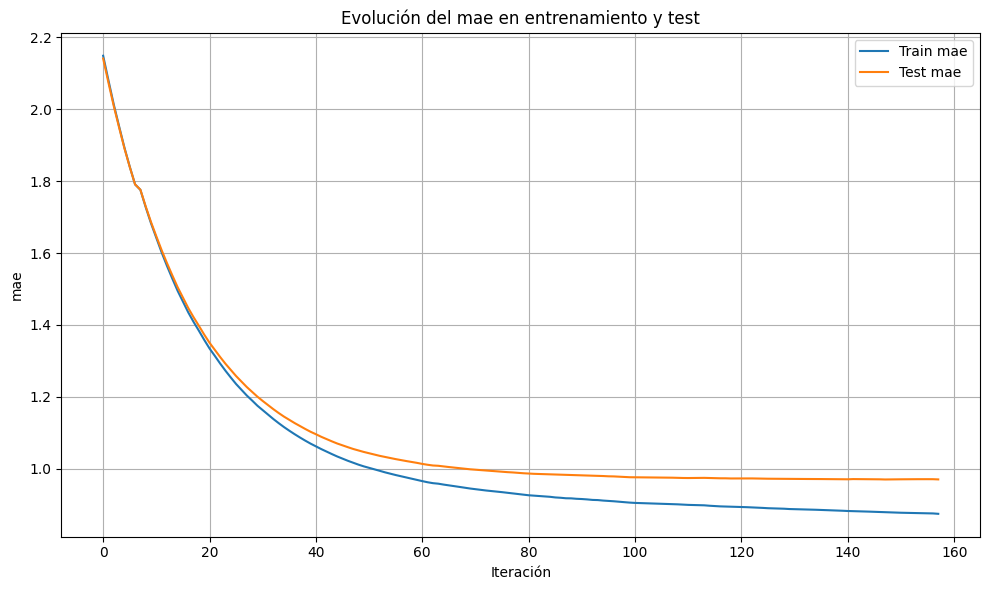

In [ ]:
results = model_puntuacion.evals_result()

# Visualizar la evoluci√≥n del RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Train mae')
plt.plot(results['validation_1']['mae'], label='Test mae')
plt.xlabel("Iteraci√≥n")
plt.ylabel("mae")
plt.title("Evoluci√≥n del mae en entrenamiento y test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Predecir sobre TODO el conjunto original
y_pred_total = model_puntuacion.predict(X)

# 2. Asegurarte de que es un array plano (1D)
y_pred_total = y_pred_total.ravel() if y_pred_total.ndim > 1 else y_pred_total

# 3. Guardar como nueva columna en el DataFrame original
df_model_puntuacion["Puntuacion_predecida"] = y_pred_total



In [ ]:
df_implantacion = df_model_puntuacion.copy()
from google.colab import files
df_model_puntuacion.to_excel("model_puntuacion.xlsx", index=False)

files.download("model_puntuacion.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Predecir y guardar
df_implantacion=df_model_puntuacion.copy()



In [ ]:
df_implantacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24646 entries, 0 to 24645
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT AGE                          24646 non-null  int64  
 1   PATIENT BMI                          24646 non-null  float64
 2   ANTIUMULLERIANA_DE                   24646 non-null  float64
 3   N_FOLIC_ANTRAL_DER_IN.-              24646 non-null  int64  
 4   N_FOLIC_ANTRAL_IZQ_IN.-              24646 non-null  int64  
 5   DOSIS TOTAL                          24646 non-null  float64
 6   RFA                                  24646 non-null  int64  
 7   ASPIRADOS_PREDICT                    24646 non-null  float64
 8   NIVEL_FSH_H_DE.-_OK                  24646 non-null  int64  
 9   P4_DHCG_DE.-                         24646 non-null  float64
 10  dias_estim_e_cl.-                    24646 non-null  int64  
 11  ampollas_fsh_e_cl.-         

In [ ]:
df_implantacion["Implantacion"]= data["Implantation"]


In [ ]:
df_implantacion.value_counts("Implantacion")

Implantacion
0.0      411
100.0    354
50.0      85
Name: count, dtype: int64

In [ ]:
data=data['Implantation'].dropna()

In [ ]:
# Filtrar solo los casos con datos de Implantacion
df_implantacion_completo = df_implantacion.dropna(subset=["Implantacion"])

print(f"üîç Registros completos para Implantacion: {len(df_implantacion_completo)}")


üîç Registros completos para Implantacion: 850


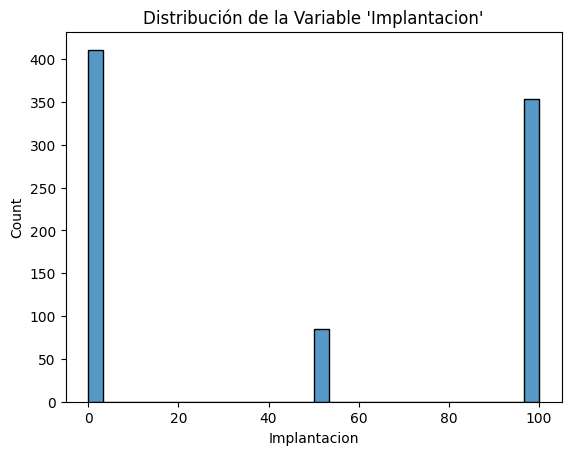

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_implantacion_completo["Implantacion"], bins=30)
plt.title("Distribuci√≥n de la Variable 'Implantacion'")
plt.show()


<ipython-input-80-c75ad6f0e615>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_implantacion_completo["Implantacion_Binaria"] = df_implantacion_completo["Implantacion"].apply(lambda x: 1 if x >= 50 else 0)


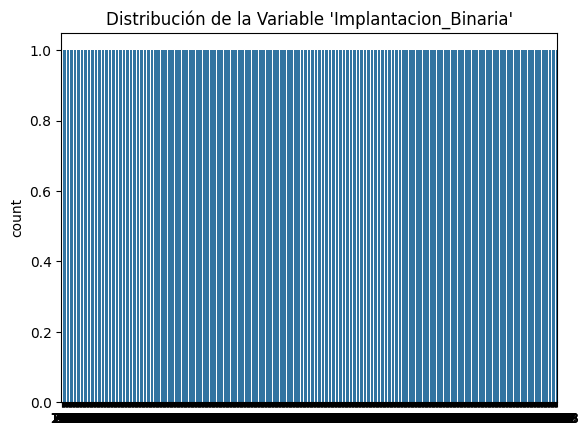

In [ ]:
# Convertir a binario (0 = no implantaci√≥n, 1 = implantaci√≥n)
df_implantacion_completo["Implantacion_Binaria"] = df_implantacion_completo["Implantacion"].apply(lambda x: 1 if x >= 50 else 0)

# Verificar la distribuci√≥n
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df_implantacion_completo["Implantacion_Binaria"])
plt.title("Distribuci√≥n de la Variable 'Implantacion_Binaria'")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd

# Filtrar solo los casos con datos completos de implantaci√≥n
df_completo = df_implantacion_completo.dropna(subset=["Implantacion_Binaria"])

# Separar las variables predictoras y el objetivo
X = df_completo.drop(columns=["Implantacion", "Implantacion_Binaria"])
y = df_completo["Implantacion_Binaria"]

# One-Hot Encoding para variables categ√≥ricas
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO_Bajo",
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO_Medio",
    "ESTIMULACI√ìN FINAL COD_1",
    "ESTIMULACI√ìN FINAL COD_2",
    "ESTIMULACI√ìN FINAL COD_3",
    "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-",
    "CALIDAD_PREDICT",
    "iDAScore v2"
]

X_encoded = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# Codificar la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Crear y entrenar el modelo XGBoost
model_xgb_implantacion = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    eval_metric="logloss",
    objective="binary:logistic",
    random_state=42,
    tree_method="hist",  # Usar hist en lugar de gpu_hist
    device="cuda",       # Usar GPU
    early_stopping_rounds=50
)

model_xgb_implantacion.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Evaluar el modelo
y_pred = model_xgb_implantacion.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Accuracy: 0.5470588235294118

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.17      0.27        82
           1       0.54      0.90      0.67        88

    accuracy                           0.55       170
   macro avg       0.57      0.53      0.47       170
weighted avg       0.57      0.55      0.48       170



In [ ]:
# Predecir sobre el conjunto codificado (no uses X, usa X_encoded)
y_pred_total = model_xgb_implantacion.predict(X_encoded)

# Aseg√∫rate de que sea un array plano
y_pred_total = y_pred_total.ravel() if y_pred_total.ndim > 1 else y_pred_total

# Guardar como nueva columna (en el DataFrame sin nulos, que fue el que usaste para entrenar)
df_completo["IMPLANTACION_PREDICT"] = y_pred_total



In [ ]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 796 entries, 68 to 26642
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT AGE                          796 non-null    int64  
 1   PATIENT BMI                          796 non-null    float64
 2   ANTIUMULLERIANA_DE                   796 non-null    float64
 3   N_FOLIC_ANTRAL_DER_IN.-              796 non-null    float64
 4   N_FOLIC_ANTRAL_IZQ_IN.-              796 non-null    float64
 5   DOSIS TOTAL                          796 non-null    float64
 6   RFA                                  796 non-null    float64
 7   ASPIRADOS_PREDICT                    796 non-null    float64
 8   NIVEL_FSH_H_DE.-_OK                  796 non-null    float64
 9   P4_DHCG_DE.-                         796 non-null    float64
 10  dias_estim_e_cl.-                    796 non-null    float64
 11  ampollas_fsh_e_cl.-               

In [ ]:
from google.colab import files
df_completo.to_excel("df_completo.xlsx", index=False)

files.download("df_completo.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cosas que he ehcho viendo que el smote esta generando un oferfiting, cmabiamos los parmatros de XGB_Classifier, paramtros a tenr en cuenta para modifcar:
n_estimator: haciedno que tenga menos tiempo para que no se mememorice los datos y el leraning_rate bajo. Min_child_weiught se usa para definir el n√∫mero minimo de datos en un nodo para no generar nodos peque√±os que puede ser solo ruido,reg_alpha regulariza debido a que elimina los datos que no son importantes, es decir que no contribuyen al error y reg_lambda=10, distribuye los pesos mas uniforme

In [ ]:
import pandas as pd

# Cargar el nuevo archivo Excel
nuevo_df = pd.read_excel("/ruta/al/archivo.xlsx", sheet_name="Nombre_Hoja")
print(nuevo_df.head())


üß† C√≥mo Funciona XGBClassifier Internamente (M√°s All√° de Multiclase)
El XGBClassifier es parte de la biblioteca XGBoost (eX**treme Gradient Boosting), que es uno de los algoritmos de machine learning m√°s potentes para clasificaci√≥n y regresi√≥n. Vamos a explorar c√≥mo funciona internamente:

üîó 1. El Fundamento: Gradient Boosting (GBM)
El Gradient Boosting es un enfoque ensemble que combina muchos √°rboles de decisi√≥n d√©biles para crear un modelo fuerte. Funciona en varias fases:

Fase 1: Construir un modelo inicial (√°rbol d√©bil).

Fase 2: Medir los errores de este modelo.

Fase 3: Crear un nuevo modelo que se enfoca en corregir estos errores.

Fase 4: Repetir el proceso hasta que el error sea lo suficientemente bajo o se alcance el n√∫mero m√°ximo de √°rboles.

üå± 2. √Årboles de Decisi√≥n (Base Learners)
Los modelos que crea son √°rboles de decisi√≥n que funcionan de la siguiente manera:

Cada √°rbol es un conjunto de nodos que dividen los datos en ramas y finalmente en hojas.

Cada hoja representa una predicci√≥n para una peque√±a parte del espacio de caracter√≠sticas.

‚öôÔ∏è 3. Funci√≥n de P√©rdida y Gradientes
XGBoost usa gradientes para ajustar los √°rboles:

Calcula el error (p√©rdida) entre las predicciones y los valores reales.

Usa este error para ajustar los pesos de los √°rboles en las siguientes iteraciones.

Los √°rboles siguientes est√°n "dirigidos" a corregir los errores de los √°rboles anteriores.

üîó 4. C√°lculo del Error y Actualizaci√≥n de los Pesos
P√©rdida (eval_metric):

Binario: logloss

Multiclase: mlogloss

Optimizaci√≥n del Error:

Se usa el m√©todo de gradiente descendente para ajustar los pesos.

¬°
Donde:

y_i es el valor real.

\hat{y_i} es la predicci√≥n.

w son los pesos de las hojas.

\lambda y \alpha son los t√©rminos de regularizaci√≥n para evitar overfitting.

üõ†Ô∏è 5. Regularizaci√≥n (reg_alpha, reg_lambda)
reg_alpha (L1 Regularizaci√≥n): Penaliza las caracter√≠sticas menos importantes, reduciendo el sobreajuste.

reg_lambda (L2 Regularizaci√≥n): Hace que los pesos de las hojas sean m√°s peque√±os y distribuidos, tambi√©n reduciendo el sobreajuste.

üîÑ 6. Creaci√≥n de los √Årboles (Tree Boosting)
Criterio de Divisi√≥n: Elige la caracter√≠stica que maximiza la ganancia de informaci√≥n en cada nodo.

Poda de √Årboles: Remueve nodos que no contribuyen significativamente a la precisi√≥n.

Colapso de Nodos: Si un nodo no tiene suficientes ejemplos (min_child_weight), no se divide.

üì¶ 7. Construcci√≥n R√°pida de √Årboles (tree_method)
XGBoost usa m√©todos avanzados para construir los √°rboles r√°pidamente:

Exact: Recorre todos los posibles puntos de divisi√≥n (lento para muchos datos).

Approx: Usa histogramas para acelerar las divisiones.

Hist: M√°s r√°pido y eficiente en memoria.

GPU_Hist: Usa GPU para acelerar a√∫n m√°s.

üìù 8. Early Stopping y Overfitting
Early Stopping: Detiene el entrenamiento si el error en el conjunto de validaci√≥n deja de mejorar.

Regularizaci√≥n: Evita que los √°rboles se ajusten demasiado a ejemplos espec√≠ficos.

üîó 9. Predicci√≥n Final (Ensamblaje)
El modelo final es la suma ponderada de todos los √°rboles:


Cada √°rbol f_t corrige los errores de los √°rboles anteriores.

Las salidas se combinan para hacer una predicci√≥n final m√°s precisa.

üìä 10. Salida del Modelo:
predict() para valores finales.

predict_proba() para probabilidades de cada clase (en multiclase).

feature_importances_ para identificar las caracter√≠sticas m√°s importantes.



In [ ]:
import pandas as pd

df_transferidos = pd.read_excel("/content/model_puntuacion (1).xlsx")

df_transferidos.head(5)

PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
0           35        24.13               14.52                        7   
1           35        24.13               14.52                        7   
2           35        24.13               14.52                        7   
3           35        24.13               14.52                        7   
4           35        24.13               14.52                        7   

   N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL  RFA  ASPIRADOS_PREDICT  \
0                        6       4100.0   13          12.119667   
1                        6       4100.0   13          12.622733   
2                        6       4100.0   13          12.622733   
3                        6       4100.0   13          12.119667   
4                        6       4100.0   13          12.119667   

   NIVEL_FSH_H_DE.-_OK  P4_DHCG_DE.-  ...  CALIDAD_PREDICT  iDAScore v2  \
0                    0           1.4  ...                1          1.1   
1                    0           1.4  ...                1          1.1   
2                    0           1.4  ...                1            1   
3                    0           1.4  ...                2          2.4   
4                    0           1.4  ...                1          1.4   

   OVO_MII_INSEMIN_IN.-_OK_GRUPO_Alto  OVO_MII_INSEMIN_IN.-_OK_GRUPO_Bajo  \
0                               False                               False   
1                               False                               False   
2                               False                               False   
3                               False                               False   
4                               False                               False   

   OVO_MII_INSEMIN_IN.-_OK_GRUPO_Medio  ESTIMULACI√ìN FINAL COD_0  \
0                                 True                     False   
1                                 True                     False   
2                                 True                     False   
3                                 True                     False   
4                                 True                     False   

   ESTIMULACI√ìN FINAL COD_1 ESTIMULACI√ìN FINAL COD_2  \
0                      True                    False   
1                      True                    False   
2                      True                    False   
3                      True                    False   
4                      True                    False   

   ESTIMULACI√ìN FINAL COD_3  Puntuacion_predecida  
0                     False              1.058097  
1                     False              1.130990  
2                     False              1.130990  
3                     False              2.352962  
4                     False              1.029469  

[5 rows x 26 columns]

In [ ]:
df_transferidos["Implantation"]=data["Implantation"]
df_transferidos["Implantation_cong"]=data["tCong_Implant"]

In [ ]:
# Casos con datos de implantaci√≥n reales
df_transferidos_filtados_impla = df_transferidos[
    (df_transferidos["Implantation"].notna()) |
    (df_transferidos["Implantation_cong"].notna())
].copy()


In [ ]:
df_transferidos_filtados_impla["IMPLANTACION_final"] = ((df_transferidos_filtados_impla["Implantation"] > 0) | (df_transferidos_filtados_impla["Implantation_cong"] > 0)).astype(int)

In [ ]:
df_transferidos_filtados_impla["IMPLANTACION_final"] .value_counts()

IMPLANTACION_final
1    1813
0    1593
Name: count, dtype: int64

In [ ]:
df_transferidos_filtados_impla["IMPLANTACION_final"]  = df_transferidos_filtados_impla["IMPLANTACION_final"].apply(lambda x: "NV" if x == 0 else "IMPLANTADO")


In [ ]:
df_transferidos_filtados_impla["IMPLANTACION_final"].value_counts()

IMPLANTACION_final
IMPLANTADO    1813
NV            1593
Name: count, dtype: int64

In [ ]:
df_transferidos_filtados_impla.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3406 entries, 3 to 24628
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT AGE                          3406 non-null   int64  
 1   PATIENT BMI                          3406 non-null   float64
 2   ANTIUMULLERIANA_DE                   3406 non-null   float64
 3   N_FOLIC_ANTRAL_DER_IN.-              3406 non-null   int64  
 4   N_FOLIC_ANTRAL_IZQ_IN.-              3406 non-null   int64  
 5   DOSIS TOTAL                          3406 non-null   float64
 6   RFA                                  3406 non-null   int64  
 7   ASPIRADOS_PREDICT                    3406 non-null   float64
 8   NIVEL_FSH_H_DE.-_OK                  3406 non-null   int64  
 9   P4_DHCG_DE.-                         3406 non-null   float64
 10  dias_estim_e_cl.-                    3406 non-null   int64  
 11  ampollas_fsh_e_cl.-               

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Separar las variables predictoras y el objetivo
X = df_transferidos_filtados_impla.drop(columns=["Implantation", "Implantation_cong", "IMPLANTACION_final"])
# Convertir "IMPLANTADO"/"NV" a binario para el modelo
y = df_transferidos_filtados_impla["IMPLANTACION_final"].apply(lambda x: 1 if x == "IMPLANTADO" else 0)



# Columnas categ√≥ricas para aplicar One-Hot Encoding
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO_Bajo",
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO_Medio",
    "ESTIMULACI√ìN FINAL COD_1",
    "ESTIMULACI√ìN FINAL COD_2",
    "ESTIMULACI√ìN FINAL COD_3",
    "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-",
    "CALIDAD_PREDICT",
    "iDAScore v2"
]

# Codificaci√≥n One-Hot (elimina la primera categor√≠a para evitar multicolinealidad)
X_encoded = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# --- 2. Dividir datos ---

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, stratify=y, test_size=0.2, random_state=42
)

# --- 3. Entrenar modelo XGBoost ---

model_xgb_implantacion_final = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    eval_metric="logloss",
    objective="binary:logistic",
    random_state=42,
    tree_method="hist",  # usa "gpu_hist" si usas GPU
    device="cuda",       # o elimina si no usas GPU
    early_stopping_rounds=50
)

model_xgb_implantacion_final.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# --- 4. Evaluar modelo ---

y_pred = model_xgb_implantacion_final.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:30:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:30:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



Accuracy: 0.5674486803519062

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.30      0.39       319
           1       0.57      0.80      0.66       363

    accuracy                           0.57       682
   macro avg       0.57      0.55      0.53       682
weighted avg       0.57      0.57      0.54       682



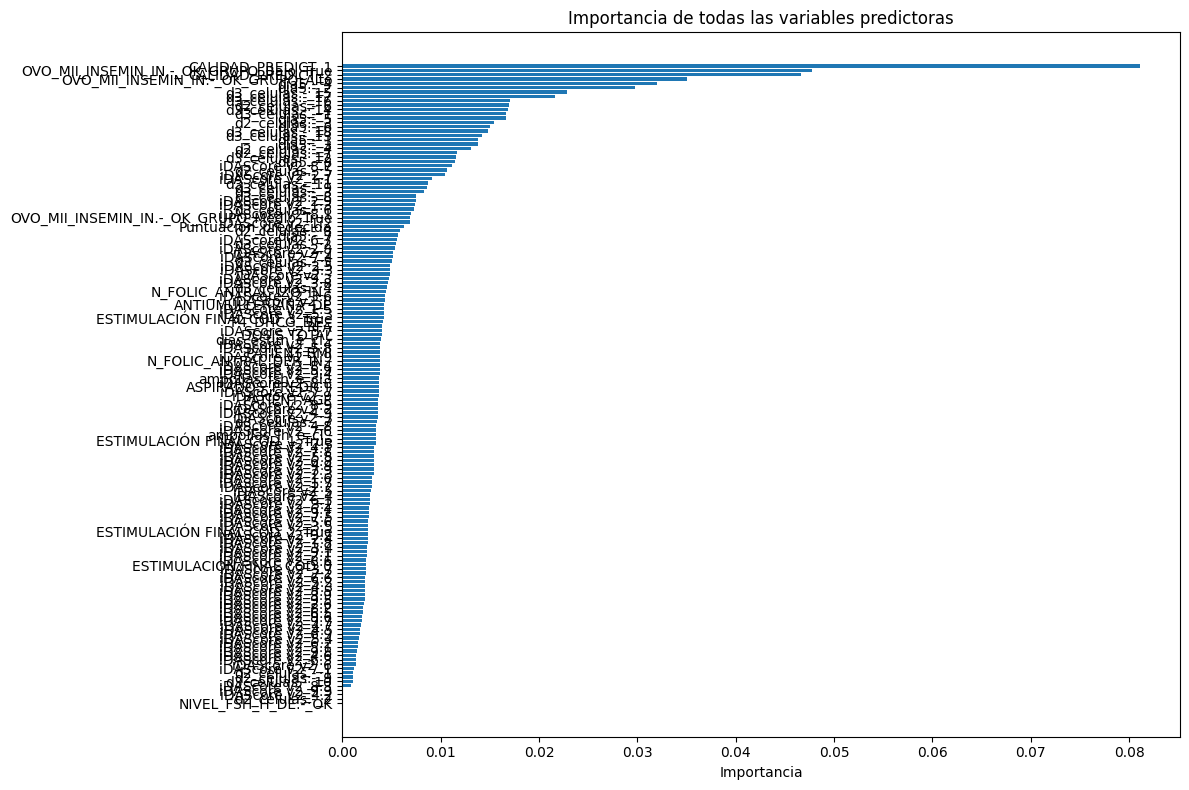

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener importancia de caracter√≠sticas
xgb_feat_importance = model_xgb_implantacion.feature_importances_
sorted_idx = np.argsort(xgb_feat_importance)[::-1]
top_features = X_train_resampled.columns[sorted_idx]

# Gr√°fico de barras horizontal con todas las variables
plt.figure(figsize=(12,8))
plt.barh(top_features, xgb_feat_importance[sorted_idx])
plt.xlabel("Importancia")
plt.title("Importancia de todas las variables predictoras")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(14605), np.int64(1): np.int64(14605)}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Get the best model from the grid search
best_model = grid_xgb.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Print classification report
print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))